# SIT384 10.2HD

<span style="color: red">**Requirements**: Students are expected to write <span style="color: blue">one paragraph summarizing</span> the task's goal, ML methods used, and chosen evaluation metrics, etc.</span>

Eample: 

The goal of this task is to investigate different methods that can be used to improve the performance of machine learning models on the heavily imbalanced credit card dataset. Such methods include feature engineering, PCA, undersampling and oversampling the majority and minority classes, etc. This task was inspired by a similar case study by Simon Delarue that delves into this topic in detail. In the following section, I will give an overview of my findings. It should also be noted that the performance was evaluated on the testing set with the ROC-AUC metric. 

<span style="color: red">**Requirements**: Students are expected to write an <span style="color: blue">**Overview** paragraph explaining the whole problem solving ideas</span> or similar. It should include: <br>
    brief introduction to the <span style="color: green">**steps**</span> adopted during the problem solving process, e.g., what decisions were made and why these decisions were made, and what were the final results, etc. </span>

Example:     

**Overview**

During the investigative phase of this task, I noticed that the dataset was heavily imbalanced, with the fraudulent (positive) class only represented in 0.173% samples of the dataset. As such, I decided to perform a baseline test of the ML models on the raw, unprocessed data. I noticed that the random forest classifier performed the best when evaluated on the testing set. As evaluating all these models took over 6 hours alone, I decided to focus my later efforts on improving the performance on just the random forest model, similar to the case study.

Afterwards, I tried using PCA and oversampling/undersampling techniques to improve performance of the baseline random forest model. Starting with PCA, I noticed that the dataset could not be represented well in an efficient number of principal components, possibly due to noise. Resulting test set scores with a variety of principal component values showed a decrease in performance; as such, I did not proceed with using PCA. On the other hand, using a combination of SMOTE and the RandomUnderSampler on the majority and minority classes resulted in a small boost to performance. As such, I used this technique for the remaining sections. 

In the original case study, enlarging the feature space was proposed to help ML models improve their performance. In my case, I used a combination of duplicate sample marking and squaring of values, as these techniques seemed the most appropriate for the dataset. Yet, trying the techniques separately and together resulted in the model overfitting on the training set and giving lower test results. So, this was not a valid approach. 

Finally, I tried using Isotonic and Sigmoid calibration on the random forest to help improve its model's consistency, and possibly test set results. At best, a slightly lower Brier score was received by using these techniques, but no discernible ROC AUC score improvements. As such, it seemed like only SMOTE improved the baseline score. 

**Results**  

In the below table, we can see the scores measured on the test set.

Best Public Test Score : __98.184 (AUC)__  

| Model|Baseline|PCA|Resampling|Enlarged features|
|------|-------------------|--------|---------|---------------|
|Random Forest|98.106%|98.001%|98.184%|97.726%|
|SVM|97.714%|-|-|-|
|XGBoost|97.724%|-|-|-|
|LightBGM|96.583%|-|-|-|
|CatBoost|97.759%|-|-|-|




<span style="color: red">**Requirements**: </span><br>
<span style="color: red">1. A table of contents is recommended for easy access to different sections of the solution. </span><br>
<span style="color: red">2. In the main body of the notebook, students are expected to demonstrate <span style="color: blue">each step they take **in detail**</span> with <br> </span></span>
<span style="color: red">
    - <span style="color: green">justification</span> of the step and methods used,<br>
    - proper <span style="color: green">code</span> and <span style="color: green">output</span>, and <br>
    - <span style="color: green">analysis</span> of the output. <br>
</span>


**Table of contents**  

1. [Utilities](#Utilities)    
    1.1. [Libraries](#Libraries)  
    1.2. [Data](#Data)  
    1.3. [Functions](#Functions)  
2. [Exploratory Data Analysis](#ExploratoryDataAnalysis)  
    2.1. [General aspect of Data](#GeneralAspect)  
    2.2. [Feature correlations](#FeatCorr)  
    2.3. [Baseline Testing](#Baseline)  
    2.4. [Principal Components Analysis (PCA)](#PCA)  
3. [Feature Engineering](#FeatureEngineering)  
    3.1. [Sampling Methods](#SamplingMethods)  
    3.2. [Enlarging Feature space](#EnlargeFeat)  
    3.3. [Train Test Split](#TrainTestSplit)   
    3.4. [Probability Calibration](#ProbCalib)
4. [Probability Evaluation](#Models)  
    4.1. [Evaluation: Validation Set](#pred_val)  
    4.2. [Evaluation: Test Set](#pred_test)  



## 1. Utilities
### 1.1 Libraries <a class="anchor" id="Libraries"></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pickle

# Install missing packages if necessary
# Added by Shang 01/05/2024
# You can uncomment this line if you face the error: ModuleNotFoundError: No module named 'scikitplot'
# %pip install scikit-plot 

import scikitplot as skplt

# Import essential libraries from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure compatibility with scikit-learn v1.2.2 for deprecated functions
# Added by Shang 01/05/2024
# If using an older version of scikit-learn:
# Before sklearn 1.2:
# from sklearn.metrics import plot_roc_curve
# svc_disp = plot_roc_curve(svc, X_test, y_test)
# rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=svc_disp.ax_)

# From sklearn 1.2 and onwards, use RocCurveDisplay:
from sklearn.metrics import RocCurveDisplay

# Added by Robin
# Downgrade scikit-learn version to 1.2.2 to avoid ImportError for missing utilities
# You can follow this if necessary:
# !pip install scikit-learn==1.2.2

# Import essential evaluation metrics from sklearn
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, \
                            recall_score, precision_score, f1_score, auc, brier_score_loss

# Import other useful libraries for machine learning
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier

# Added by Shang 01/05/2024
# Install and import XGBoost if necessary
# If you encounter ModuleNotFoundError, use the following:
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# Added by Shang 01/05/2024
# Install and import LightGBM if necessary
# !pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Added by Shang 01/05/2024
# Install and import CatBoost if necessary
# !pip install catboost
import catboost as cbt
from catboost import CatBoostClassifier

# Import SVM, grid search, and other utilities from sklearn
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

# Imbalanced data handling with SMOTE and undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Calibrating classifiers for probability outputs
from sklearn.calibration import CalibratedClassifierCV

# Silence unnecessary warnings
import warnings
warnings.filterwarnings('ignore')


D:\anaconda\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


<span style="color: red">**Requirements**: dataset read and proper value scaling if necessary. For example, "Amount" to be scaled, "Time" and old "Amount" feature to be removed.</span>

### 1.2 Importing and fixing the csv file
Based off 10.1D, let's normalise the Amount column and drop the Time column before continuing. 

In [3]:
# Load the dataset 
df = pd.read_csv('creditcard.csv')

# Rescale the 'Amount' column using StandardScaler and create a new column 'normAmount'
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

# Drop the 'Time' and original 'Amount' columns as they are not required for further analysis
df = df.drop(['Time', 'Amount'], axis=1)

# Display the first few rows to ensure the changes are applied correctly
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


<span style="color: red">**Requirements**: Split the dateset as suggested (e.g. at ratio 0.3) with random_state set. Statistical info about the split datasets expected, such as shape, sample count.</span>

### 1.3 Data  <a class="anchor" id="Data"></a>
Let's split the dataset into training and testing sets. Also check their shapes.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame already loaded with data

# Get data points and labels
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class'].values.ravel()  # Flatten y if it's a 2D array

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Reset indices to avoid issues with non-existent indices
X_train = X_train.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)  # Convert to Series for consistency
X_test = X_test.reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)  # Convert to Series for consistency

# View shapes
print(f'X_train\'s shape : {X_train.shape}')
print(f'y_train\'s shape : {y_train.shape}')
print(f'X_test\'s shape  : {X_test.shape}')
print(f'y_test\'s shape  : {y_test.shape}')

# Statistical info
print("\nStatistical info of training set:")
print(X_train.describe())
print("\nStatistical info of testing set:")
print(X_test.describe())


X_train's shape : (199364, 29)
y_train's shape : (199364,)
X_test's shape  : (85443, 29)
y_test's shape  : (85443,)

Statistical info of training set:
                  V1             V2             V3             V4  \
count  199364.000000  199364.000000  199364.000000  199364.000000   
mean        0.000315      -0.002690      -0.001532       0.000721   
std         1.963554       1.657379       1.516716       1.417138   
min       -46.855047     -63.344698     -33.680984      -5.560118   
25%        -0.921539      -0.601213      -0.892838      -0.848835   
50%         0.019705       0.063784       0.177888      -0.017852   
75%         1.316707       0.802437       1.025529       0.745566   
max         2.451888      22.057729       9.382558      16.715537   

                  V5             V6             V7             V8  \
count  199364.000000  199364.000000  199364.000000  199364.000000   
mean       -0.001494      -0.000210      -0.000870      -0.001980   
std         1.368744

### 1.4 Functions  <a class="anchor" id="Functions"></a>

Here we define a few functions that we will use later in the project.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from sklearn.model_selection import GridSearchCV

def apply_PCA(X, plot=True):
    ''' Fit PCA on data, then plot explained variance if needed 
        Parameter
        ----------
            X : Dataframe that will be scaled and transformed according to PCA 
            plot : Boolean. If True, displays the explained variance by principal components of PCA 
        
        Output
        -------
            Array of principal components resulting from PCA
            Vector of explained variance 
    '''
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # By default keeps all components
    pca = PCA()
    pca_comp = pca.fit_transform(X_scaled)
    explained_var = pca.explained_variance_ratio_
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(range(0, len(explained_var)), explained_var.cumsum(), marker='o')
        ax.set(xlabel='Principal components', ylabel='Inertia')
        plt.axvline(x=11, color='r', linestyle='--')
        plt.title('Amount of inertia explained by principal components', fontweight='bold')
        plt.show()
    
    return pca_comp, explained_var

def plot_pca_3D(pca_components, labels):
    ''' Plot values of principal components of PCA 
        Parameters
        -----------
            pca_components : Array resulting from fitting PCA to data
            labels : ground truth labels from data 
    '''
    
    not_fraud = pca_components[labels['Class'] == 0]
    fraud = pca_components[labels['Class'] == 1]
    
    plot3D = plt.figure().add_subplot(projection='3d')

    # First, second and third principal components in each x, y and z variable
    plot3D.scatter(fraud[:, 2], fraud[:, 0], fraud[:, 1], label='Fraudulent transactions', color='r', alpha=1)
    plot3D.scatter(not_fraud[:, 2], not_fraud[:, 0], not_fraud[:, 1], label='Not fraudulent', color='g', alpha=0.2)    
    plot3D.set_xlabel('First Component')
    plot3D.set_ylabel('Second Component')
    plot3D.set_zlabel('Third Component')
    plt.legend()
    plt.show()

def plot_learning_auc(cv, model_name, ax):
    ''' Plot mean AUC learning curve based on cross validation result table (Gradient Boosting methods)
        Parameters
        -----------
            cv : Gradient boosting cross validation output DataFrame
            model_name : String for plot title 
            ax : Location of plot in the figure (ex: ax[0])
            
        Output
        -----------
            ax : Return ax to fill figure 
    '''
    
    ax.plot(range(cv.shape[0]), cv['train-auc-mean'], label='Train AUC', color='b')
    ax.plot(range(cv.shape[0]), cv['test-auc-mean'], label='Valid AUC', color='g')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Mean AUC')
    ax.set_title(f'Learning curve - {model_name}', fontweight='bold')
    ax.legend()
    return ax

def plot_roc_curve_manual(y, y_pred, model_name, ax, title):
    ''' Plot ROC Curve based on model predictions, with focus on AUC metric 
        Parameters
        -----------
            y : Array of ground truth values to predict
            y_pred : Array of predictions (i.e output of model)
            model_name : String for plot title
            ax : Location of plot in the figure (ex. ax[0])
        
        Output
        -----------
            ax : Return ax to fill figure 
    '''
    
    fpr, tpr, _ = roc_curve(y, y_pred)
    ax.plot(fpr, tpr, label=f'AUC {model_name} : {roc_auc_score(y, y_pred):.5f}')
    ax.plot([0, 1], [0, 1], ls='--', color='black')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title, fontweight='bold')
    ax.legend(prop={'size': 11})
    return ax

def calibrate_predictions(classifier, X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_test, cv, method):
    ''' Calibrate predictions in order to get more intuition about the probability of an item being an anomaly
        Parameters
        -----------
            classifier : Classifier model to calibrate
            X_train, y_train, X_test, y_test : Datasets for training and test (or validation)
            sample_weight_train, sample_weight_test : Weights of target value in the original dataset
            cv : Cross-validation set
            method : Method used to calibrate predictions : ['Isotonic', 'Sigmoid']
        
        Output
        -----------
            clf_calib : Fitted classifier
            preds_calib : Calibrated predictions with respect to the method (output is base on predict_proba() function)
            clf_brier_score : Brier Score of calibration 
    '''
    
    # Fit calibratedClassifier
    clf_calib = CalibratedClassifierCV(classifier, cv=cv, method=method)
    clf_calib.fit(X_train, y_train, sample_weight=sample_weight_train)
    
    # Predictions
    preds_calib = clf_calib.predict_proba(X_test)[:, 1]
    
    # Brier Score
    clf_brier_score = brier_score_loss(y_test, preds_calib, sample_weight=sample_weight_test.ravel())
    
    return clf_calib, preds_calib, clf_brier_score

def plot_predictions(y_pred, calibration_type, brier_score, ax):
    ''' Plot calibrated predictions
        Parameter
        ----------
            y_pred : Array of predictions (i.e output of model)
            calibration_type : Method used for calibration
            brier_score : Brier score (output of calibration)
            ax : Location of plot in the figure (ex. ax[0])

        Output
        ---------
            ax : Return ax to fill figure 
    '''
    
    ax.plot(range(len(y_pred)), np.sort(y_pred), label=f'{calibration_type} ({brier_score:.4f})')
    ax.legend()
    ax.set_title('Model predictions by calibration type (Brier score)', fontweight='bold')
    ax.set_ylabel('$P(Y=1)$')
    ax.set_xlabel('Instances (ordered)')
    return ax

def clf_plot_predict(clf, params, model_name, title, x_train, y_train, x_test, y_test):
    ''' Train and plot predictions using the classifier and parameters provided
        Parameters
        ----------
            clf : Classifier to train
            params : Dictionary of parameters for GridSearchCV
            model_name : String for plot title
            title : String for figure title
            x_train, y_train : Training data
            x_test, y_test : Test data
    '''
    
    searchCV = GridSearchCV(
        estimator=clf, 
        param_grid=params, 
        scoring='roc_auc',
        cv=5,
        verbose=False,
        n_jobs=-1  # Utilise all CPU cores to reduce waiting times
    )

    searchCV.fit(x_train, y_train)
    print(f'Best AUC score (training) : {searchCV.best_score_}')
    print(f'Best params : {searchCV.best_params_}')

    # Predictions
    preds_cv = searchCV.best_estimator_.predict_proba(x_test)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_roc_curve_manual(y_test, preds_cv[:, 1], model_name, ax, title)
    plt.show()


<span style="color: red">**Requirements**: Students are expected to conduct some exploratory analysis before going deeper in the data analysis. This exploratory analysis may include (but is not limited to): </span>
- <span style="color: red">are there any missing values (NaN)</span>  
- <span style="color: red">are there any duplicated values</span>
- <span style="color: red">is the dataset imbalanced</span>
- <span style="color: red">is there a difference between the features in the training and test sets</span>  
- <span style="color: red">differences between features distribution in anomaly/not anomaly classes
    </span>
- <span style="color: red">...</span>

## 2. Exploratory Data Analysis <a class="anchor" id="ExploratoryDataAnalysis"></a>

### 2.1 General aspect of data  <a class="anchor" id="GeneralAspect"></a>  

Before going deeper in the data analysis, let's check out some general aspects of the dataset ; 
- are there any missing values (NaN)  
- are there any duplicated values
- is the dataset imbalanced
- is there a difference between the features in the training and test sets  
- differences between features distribution in anomaly/not anomaly classes

**Missing values**  
None of the datasets contain missing values.

In [9]:
import pandas as pd

# Assuming the datasets are already loaded as X_train, X_test, y_train, y_test
# Example:
# X_train = pd.read_csv('X_train.csv')
# X_test = pd.read_csv('X_test.csv')
# y_train = pd.read_csv('y_train.csv')
# y_test = pd.read_csv('y_test.csv')

# Checking for Missing Values in the datasets
print(f'Missing values in X_train : {X_train.isnull().sum().sum()}')
print(f'Missing values in y_train : {y_train.isnull().sum().sum()}')
print(f'Missing values in X_test  : {X_test.isnull().sum().sum()}')
print(f'Missing values in y_test  : {y_test.isnull().sum().sum()}')


Missing values in X_train : 0
Missing values in y_train : 0
Missing values in X_test  : 0
Missing values in y_test  : 0


**Duplicated values**  
Some values are duplicated in the dataset, and we will focus on them in the _Feature Engineering_ part.

In [11]:
import pandas as pd

# Assuming the datasets are already loaded as X_train, X_test, y_train, y_test
# Example:
# X_train = pd.read_csv('X_train.csv')
# X_test = pd.read_csv('X_test.csv')
# y_train = pd.read_csv('y_train.csv')
# y_test = pd.read_csv('y_test.csv')

# Checking for Duplicate Values in the datasets
print(f'Duplicated values in X_train : {X_train.duplicated().sum()}')
print(f'Duplicated values in y_train : {y_train.duplicated().sum()}')
print(f'Duplicated values in X_test  : {X_test.duplicated().sum()}')
print(f'Duplicated values in y_test  : {y_test.duplicated().sum()}')


Duplicated values in X_train : 5161
Duplicated values in y_train : 199362
Duplicated values in X_test  : 1375
Duplicated values in y_test  : 85441


**Imbalanced classes**

We can see that the classes are severely imbalanced in the overall dataset, with fraudulent transactions accounting for only 492 samples in comparison to regular transactions at 284315 samples. This means fraudulent transactions only account for 0.173% out of the total transactions.

In [13]:
import pandas as pd

# Assuming y_train and y_test contain the target labels, where 1 represents the anomaly/fraud and 0 represents normal transactions

# Checking class distribution in y_train
class_distribution_train = y_train.value_counts(normalize=True)
class_distribution_test = y_test.value_counts(normalize=True)

# Printing the imbalance in percentages
print(f'Class distribution in y_train:\n{class_distribution_train * 100}\n')
print(f'Class distribution in y_test:\n{class_distribution_test * 100}\n')

# Checking total counts
fraud_train = y_train.value_counts()[1]
not_fraud_train = y_train.value_counts()[0]
fraud_test = y_test.value_counts()[1]
not_fraud_test = y_test.value_counts()[0]

print(f'Total samples in y_train: {len(y_train)}')
print(f'Fraudulent transactions in y_train: {fraud_train} ({(fraud_train / len(y_train)) * 100:.2f}%)')
print(f'Regular transactions in y_train: {not_fraud_train} ({(not_fraud_train / len(y_train)) * 100:.2f}%)\n')

print(f'Total samples in y_test: {len(y_test)}')
print(f'Fraudulent transactions in y_test: {fraud_test} ({(fraud_test / len(y_test)) * 100:.2f}%)')
print(f'Regular transactions in y_test: {not_fraud_test} ({(not_fraud_test / len(y_test)) * 100:.2f}%)\n')


Class distribution in y_train:
0    99.82695
1     0.17305
Name: proportion, dtype: float64

Class distribution in y_test:
0    99.827955
1     0.172045
Name: proportion, dtype: float64

Total samples in y_train: 199364
Fraudulent transactions in y_train: 345 (0.17%)
Regular transactions in y_train: 199019 (99.83%)

Total samples in y_test: 85443
Fraudulent transactions in y_test: 147 (0.17%)
Regular transactions in y_test: 85296 (99.83%)



**Features coherence between train and test sets**  
The training and test sets both contain 29 features, and these features are the same. 

In [15]:
# Check if features in the training and test sets are the same
train_features = X_train.columns
test_features = X_test.columns

if train_features.equals(test_features):
    print("The training and test sets contain the same features.")
    print(f"Number of features in train and test sets: {len(train_features)}")
else:
    print("The training and test sets have different features.")
    print(f"Features in training set: {list(train_features)}")
    print(f"Features in test set: {list(test_features)}")


The training and test sets contain the same features.
Number of features in train and test sets: 29


**Features distributions by classes**  
We take a quick look a the features distribution by target class. By comparing boxplots, we would be able to spot features which have specific distribution if the item is fraudulent or not. In n general, we can see that many of the normal samples have significant outlier values. 

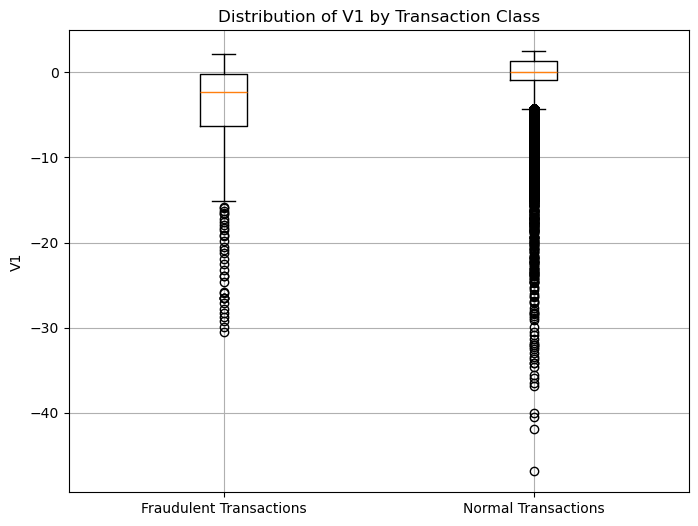

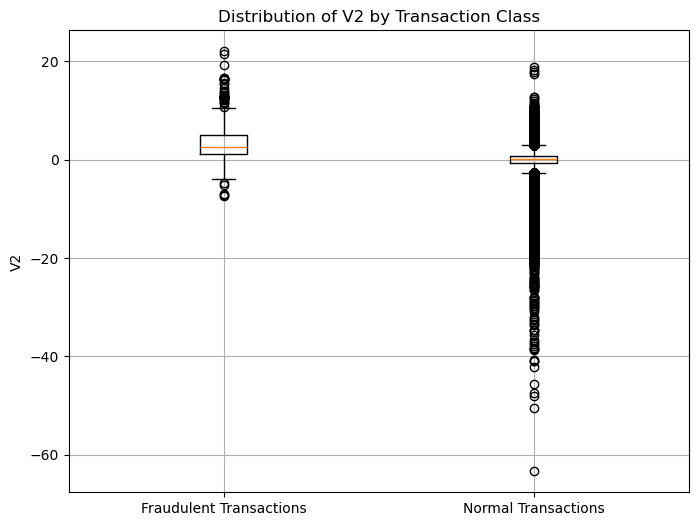

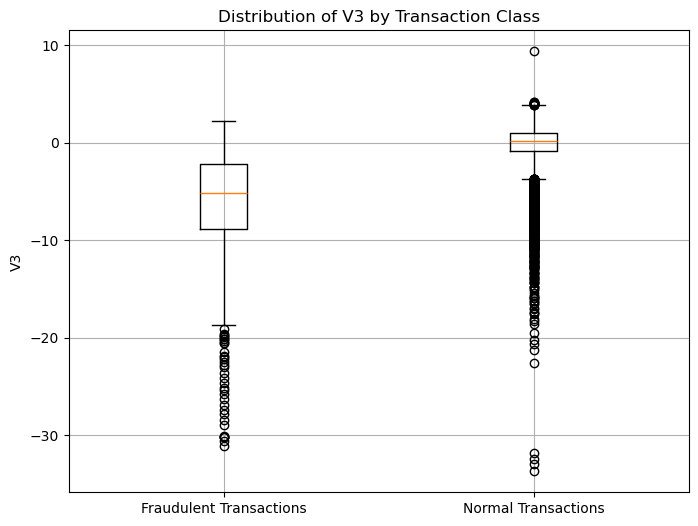

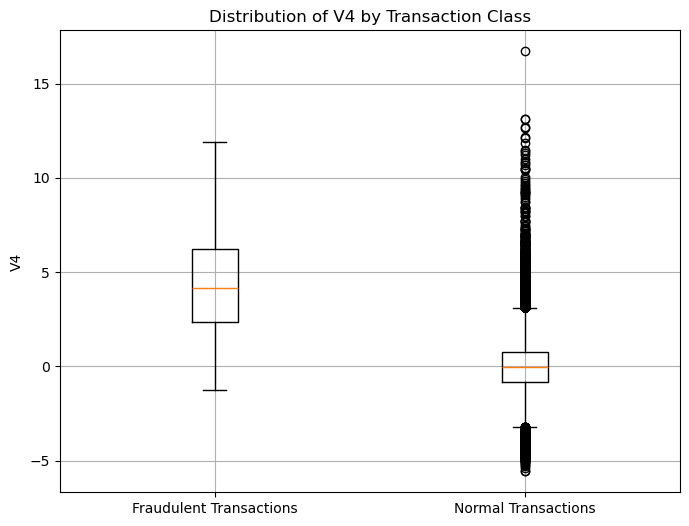

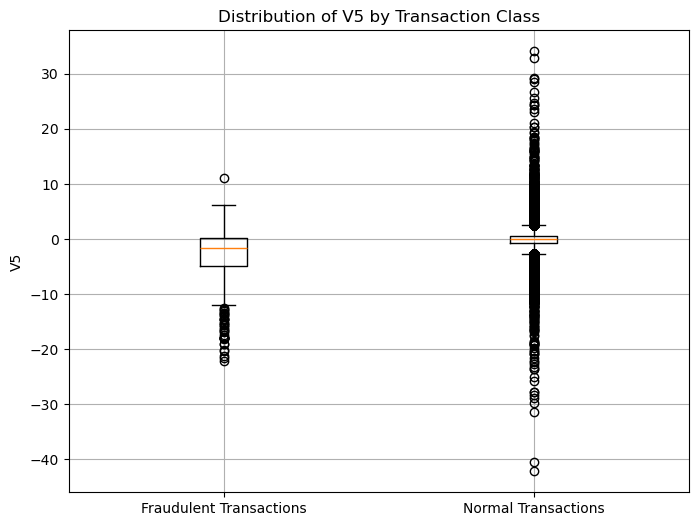

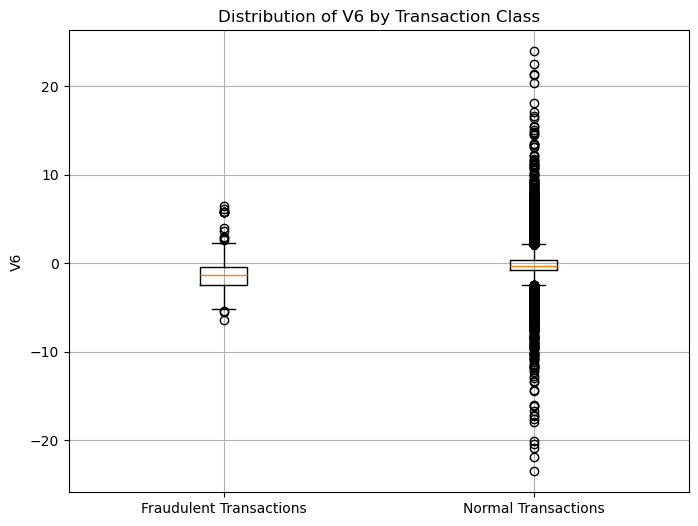

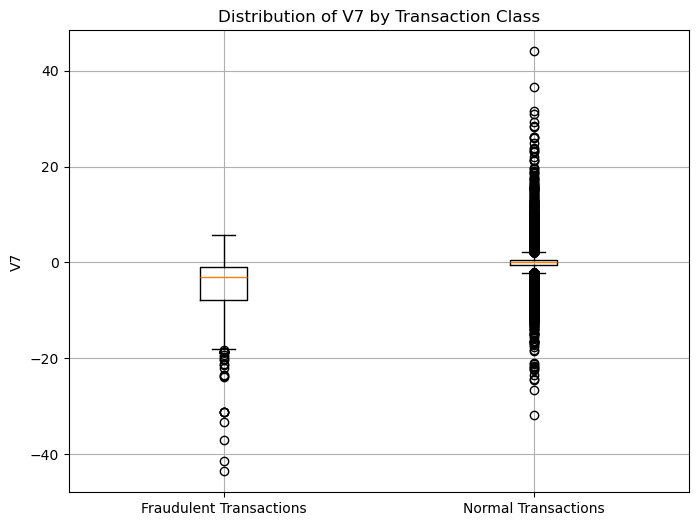

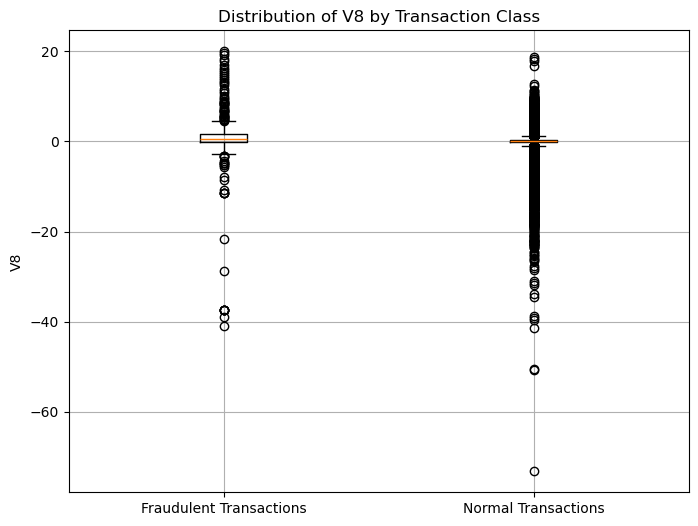

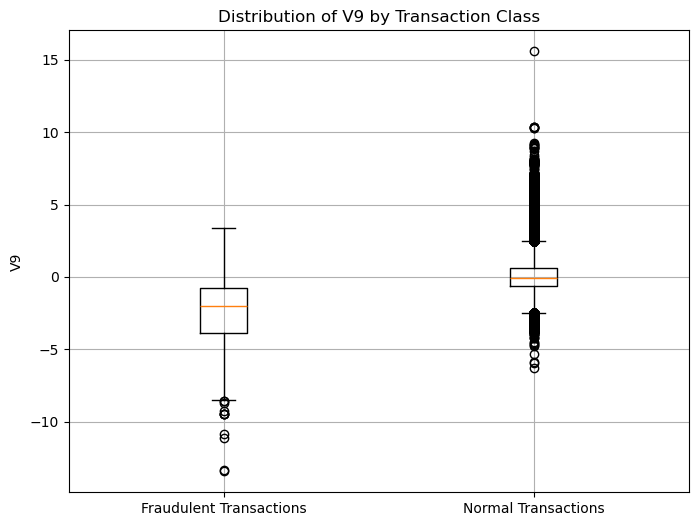

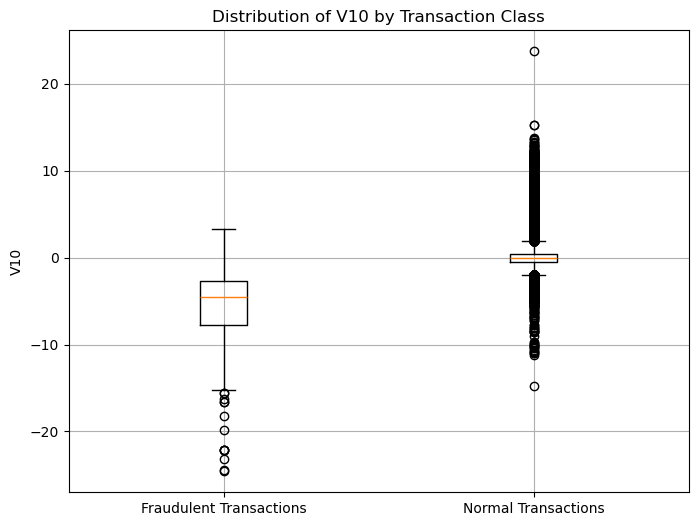

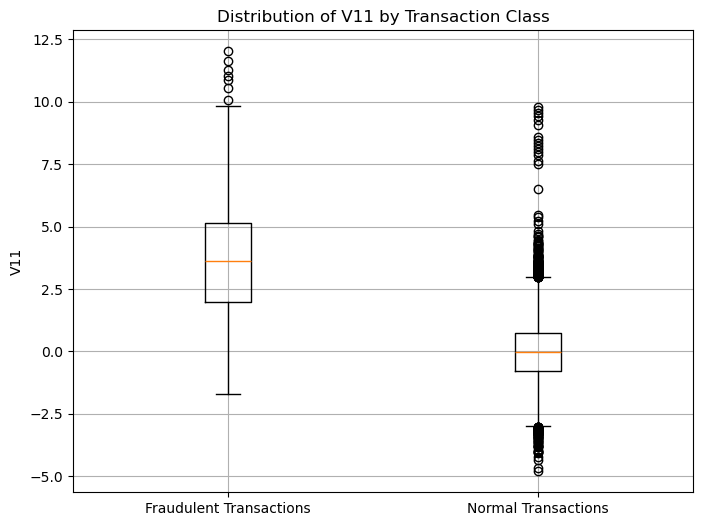

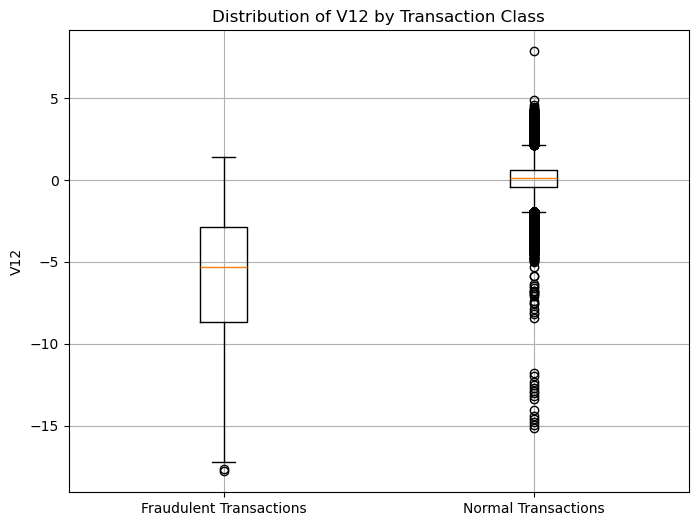

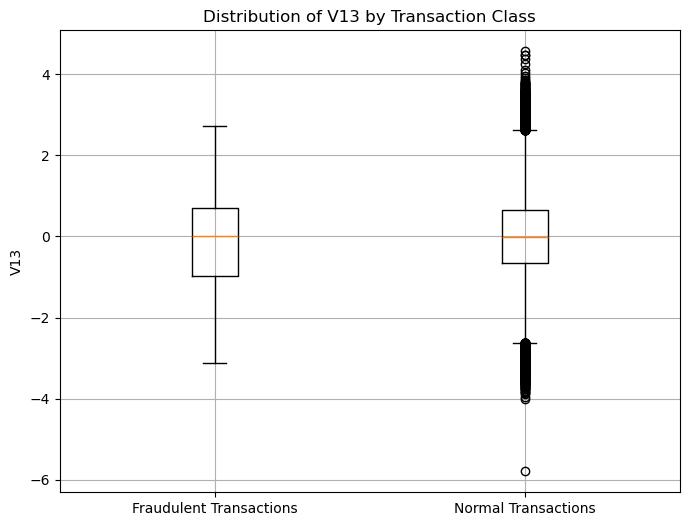

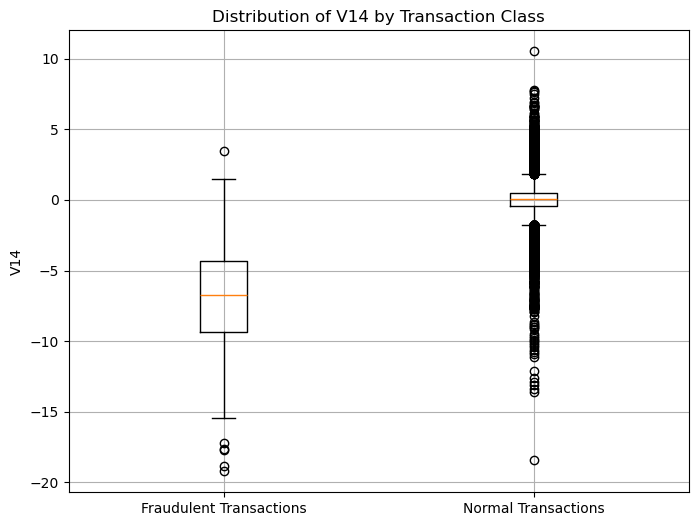

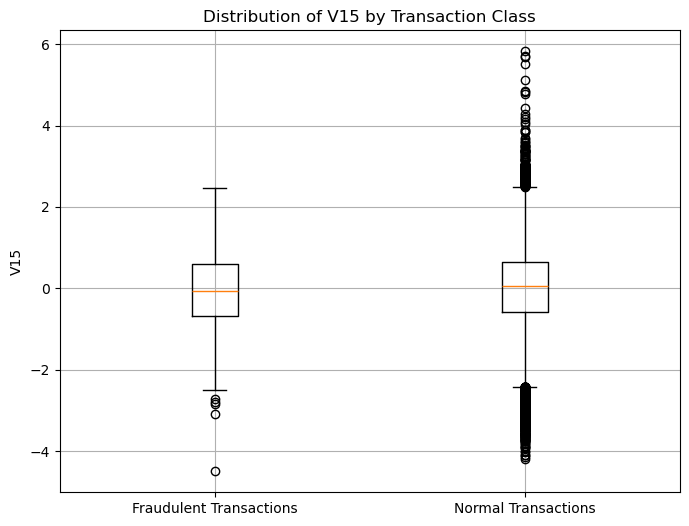

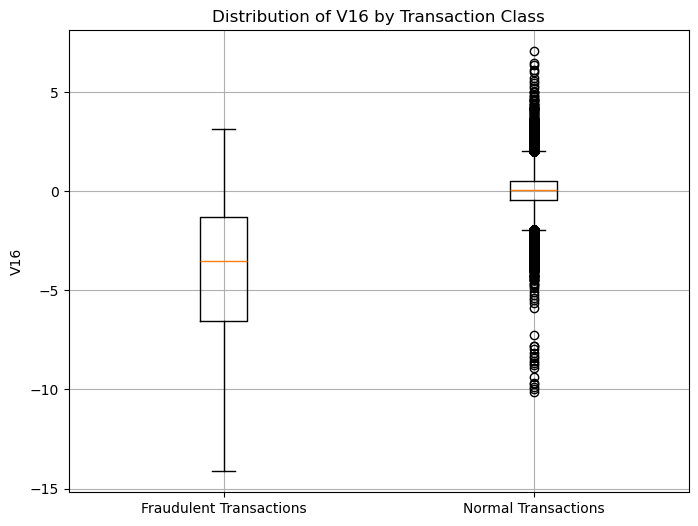

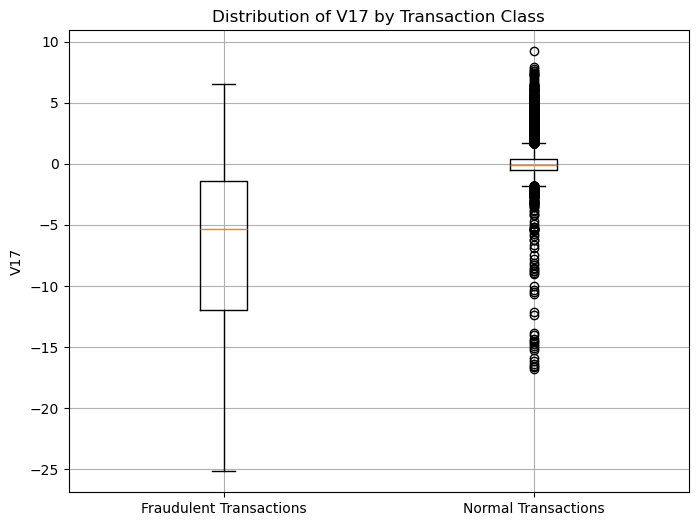

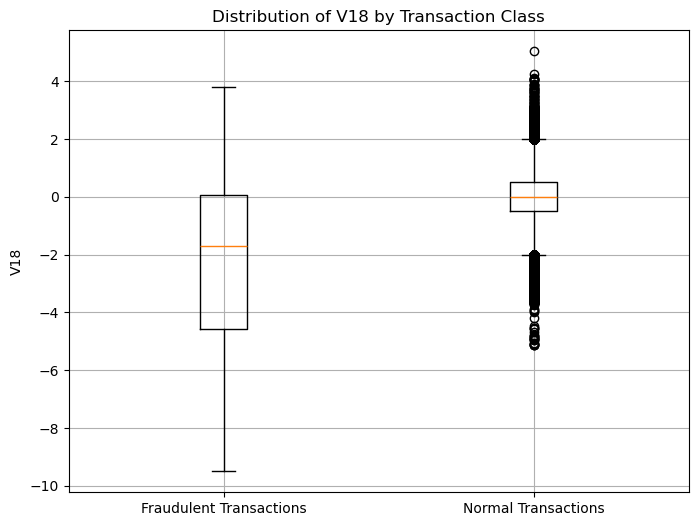

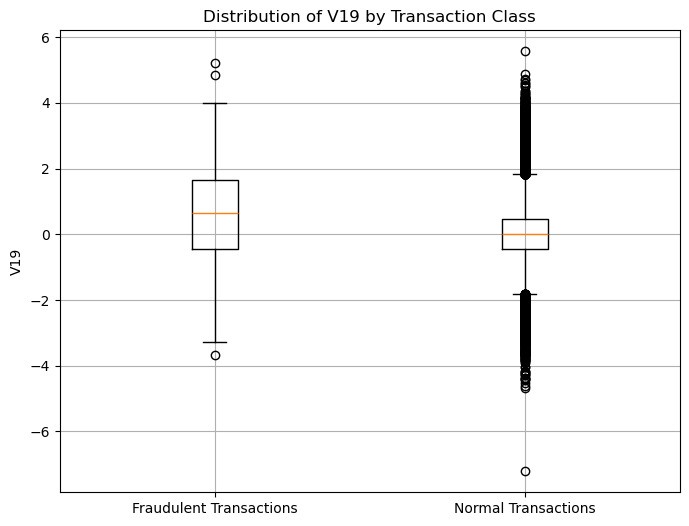

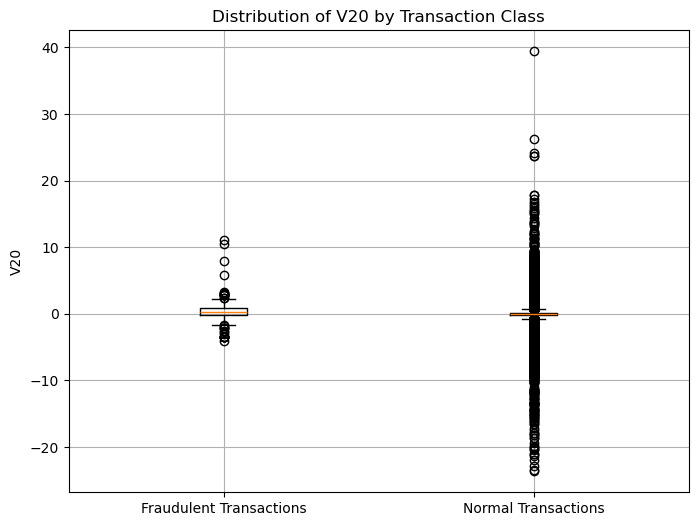

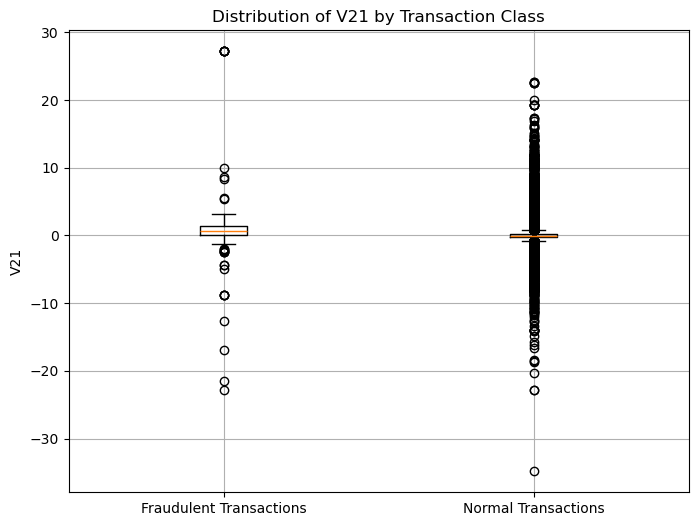

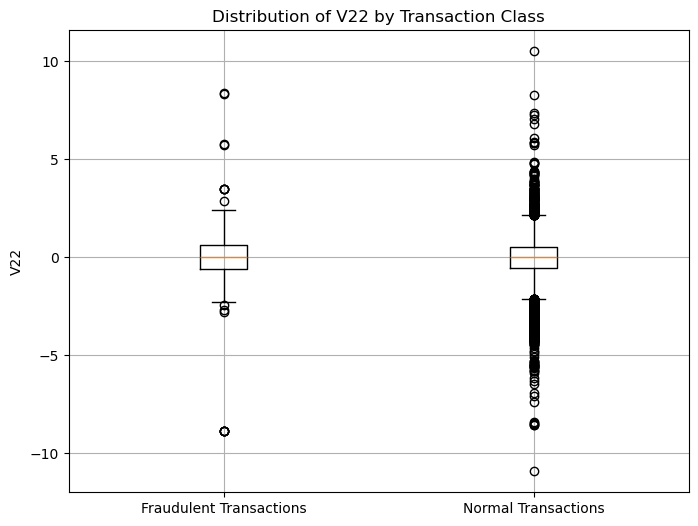

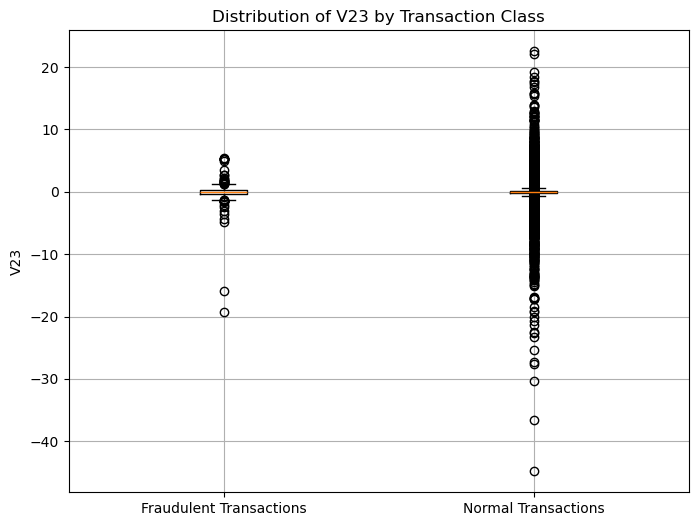

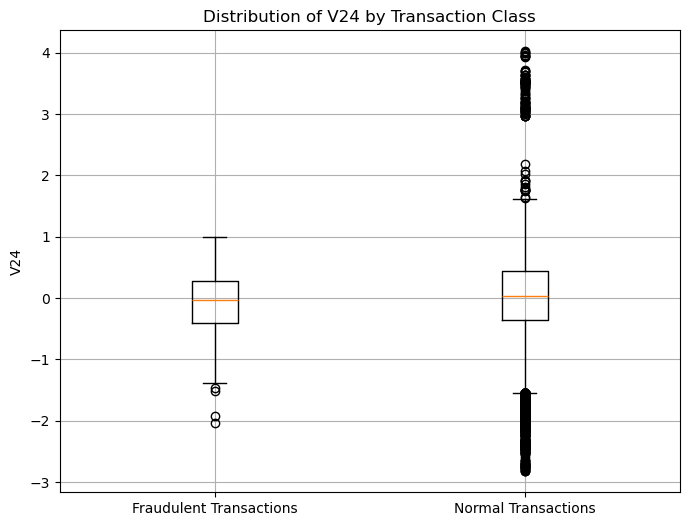

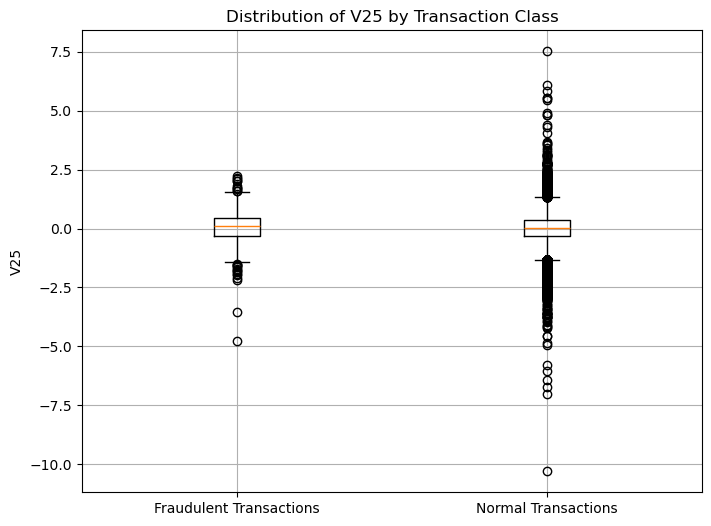

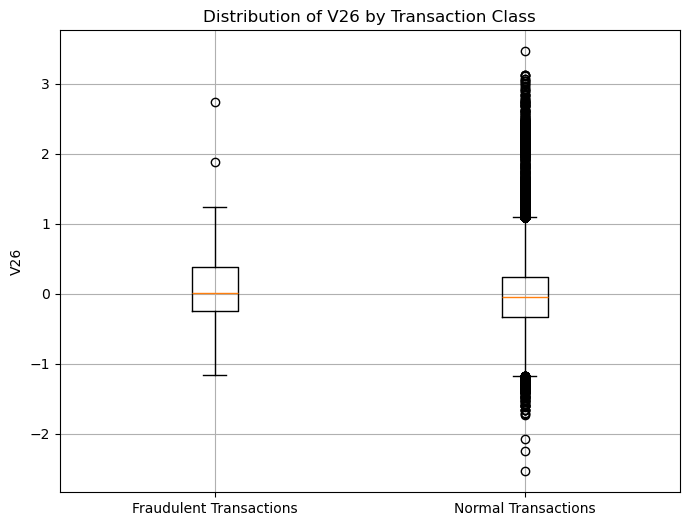

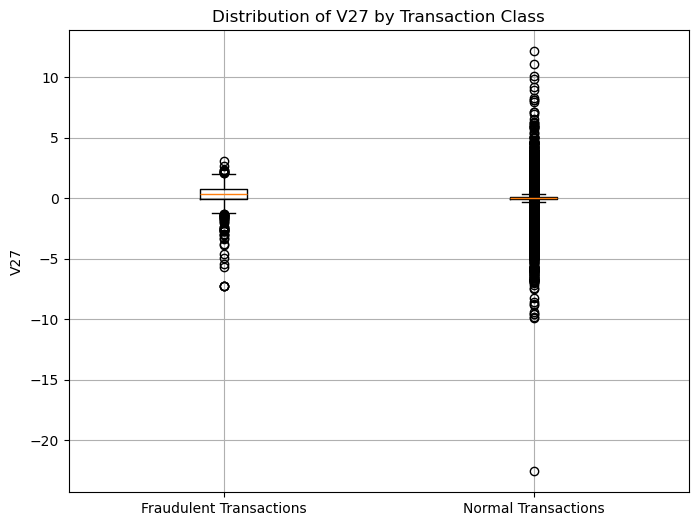

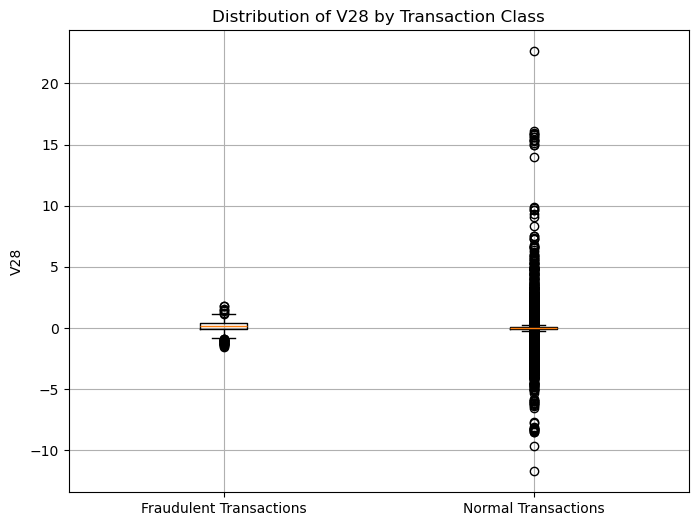

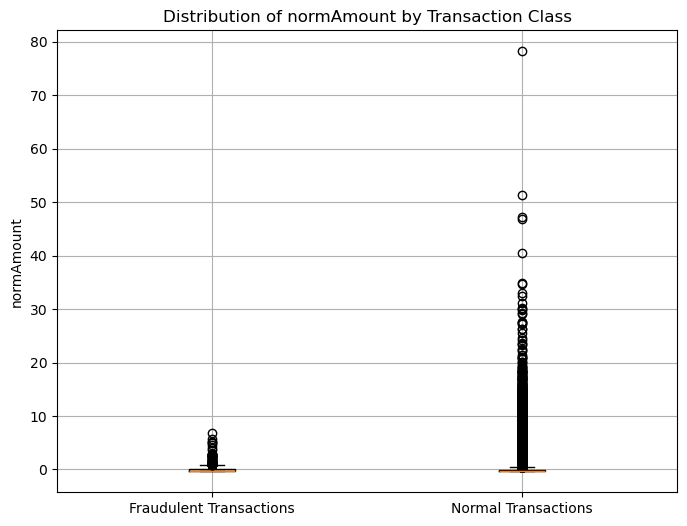

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X_train and y_train are already defined and contain your training data
# y_train should be a Series with 1 for fraudulent and 0 for normal transactions

# Ensure y_train is treated as a Series and get its values
if isinstance(y_train, pd.Series):
    y_train_values = y_train.values
else:
    y_train_values = y_train['Class'].values  # Assuming y_train is a DataFrame

# Separate fraudulent and benign transactions
fraudulent = X_train[y_train_values == 1]
benign = X_train[y_train_values == 0]

# Loop through all features to create boxplots
for feature in X_train.columns:
    # Check if the feature is numeric
    if pd.api.types.is_numeric_dtype(X_train[feature]):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        plt.boxplot([fraudulent[feature], benign[feature]])
        plt.title(f'Distribution of {feature} by Transaction Class')
        plt.xticks([1, 2], ['Fraudulent Transactions', 'Normal Transactions'])
        plt.ylabel(feature)  # Add y-axis label for clarity
        plt.grid()  # Optional: Add grid for better readability
        plt.show()


### 2.2 Feature correlations  <a class="anchor" id="FeatCorr"></a>  
It can be interesting to get an intuition about the correlations between features, and the correlations between each feature and the target. We can see that the most diverse correlations seem to be related to normAccount and every other feature.

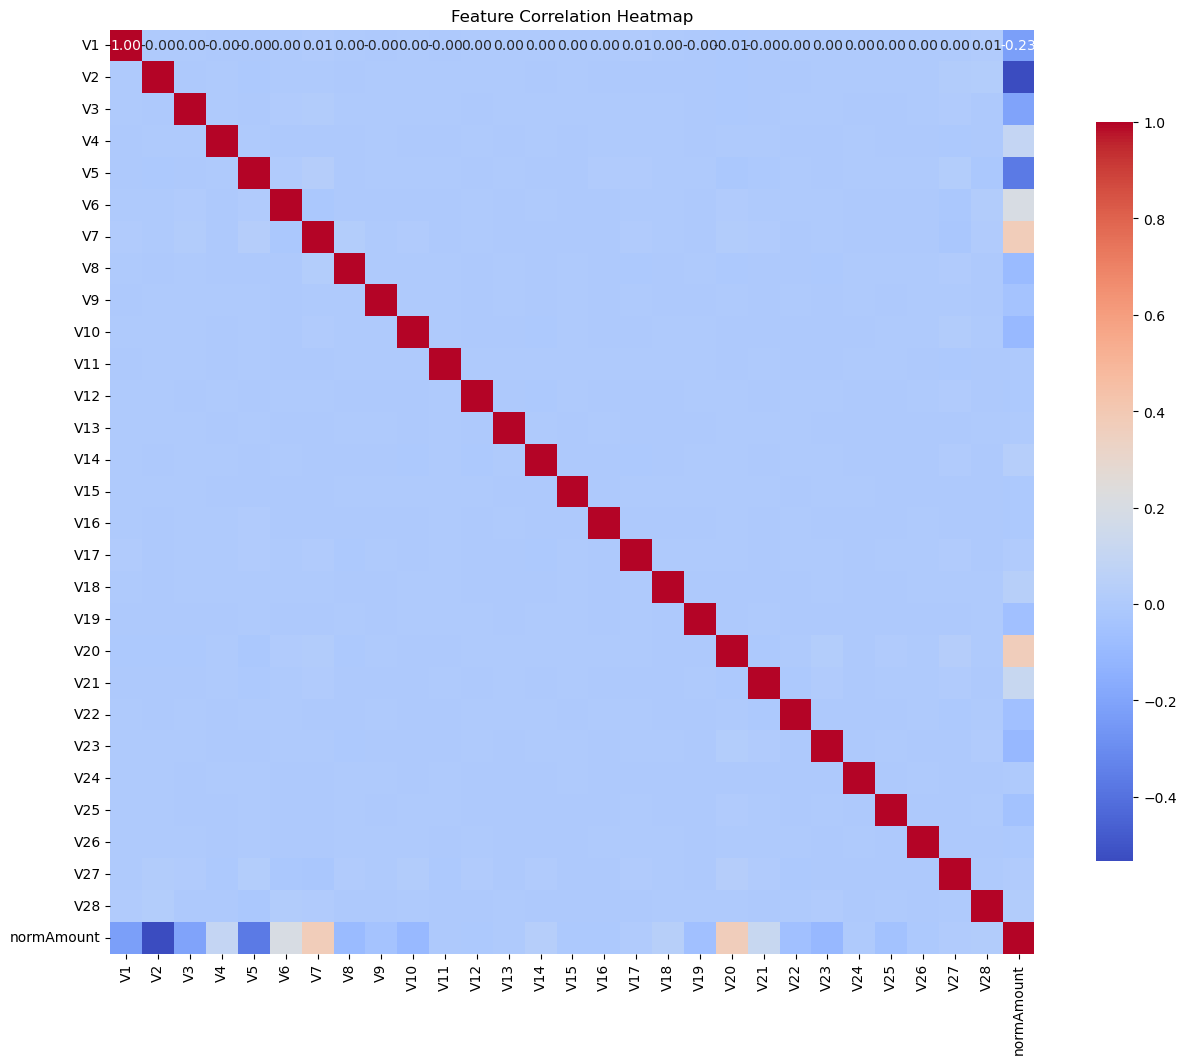

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train is already defined and contains your training data

# Calculate the correlation matrix
corr = X_train.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap')
plt.show()


**Feature correlation with target**

Roughly half of the features have a somewhat significant correlation to the targets, but none are highly correlated.

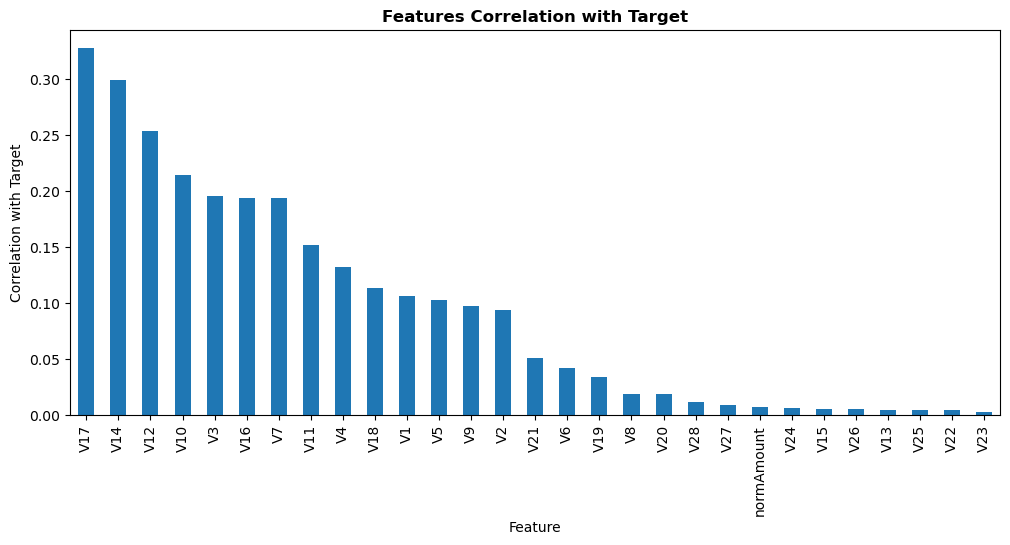

In [21]:
# Ensure y_train is a DataFrame with the correct column name
if isinstance(y_train, pd.Series):
    y_train = y_train.to_frame(name='Class')  # Convert Series to DataFrame with 'Class' column

# Concatenate X_train and y_train
df_combined = pd.concat([X_train, y_train], axis=1)

# Check if 'Class' column exists in the concatenated DataFrame
if 'Class' not in df_combined.columns:
    print("Error: 'Class' column not found in concatenated DataFrame")

# Calculate absolute correlations with the target variable 'Class'
corr_target = np.abs(df_combined.corr()['Class']).sort_values(ascending=False)[1:]

# Plotting the bar plot for feature correlations
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
corr_target.plot(kind='bar', ax=ax)
plt.title('Features Correlation with Target', fontweight='bold')
plt.ylabel('Correlation with Target')
plt.xlabel('Feature')
plt.show()


<span style="color: red">**Requirements**: Students are expected to use multiple ML algorithms to fit the initial training dataset, establishing baseline model for further improvement. The ML algorithms can be KNN, RF, SVM, SVM, XGBoost, LightGBM and CatBoost, etc. </span>
- <span style="color: red">best params grid-searched for each algorithm. Param grid can be selected based on the given case study or students' choice. </span>  
- <span style="color: red">relevant plots created for each algorithm to illustrate the outcome of exploratory analysis. e.g. ROC-AUC on test dataset.</span>
- <span style="color: red">a brief summary/discusison for this exploratory analysis.</span>


### 2.3 Baseline testing <a class="anchor" id="Baseline"></a>  
Let's try using the random forest, SVM, XGBoost, LightGBM and CatBoost ML algorithms on the initial training data (X_train, y_train), before attempting to process the sets. Scores will be measured using the AUC metric on the training set before evaluation on the test set. This will help establish a baseline for further improvement. 

First, using GridSearchCV, the best parameters will be derived from the training set. Then, we will show the cross validation scores and evaluate on the test set.

**2.3.1 Random Forest**

Running a grid search on the random forest classifier to find best params. Param types derived from the case study.

ROC AUC score for Random Forest: 0.9761502800332288


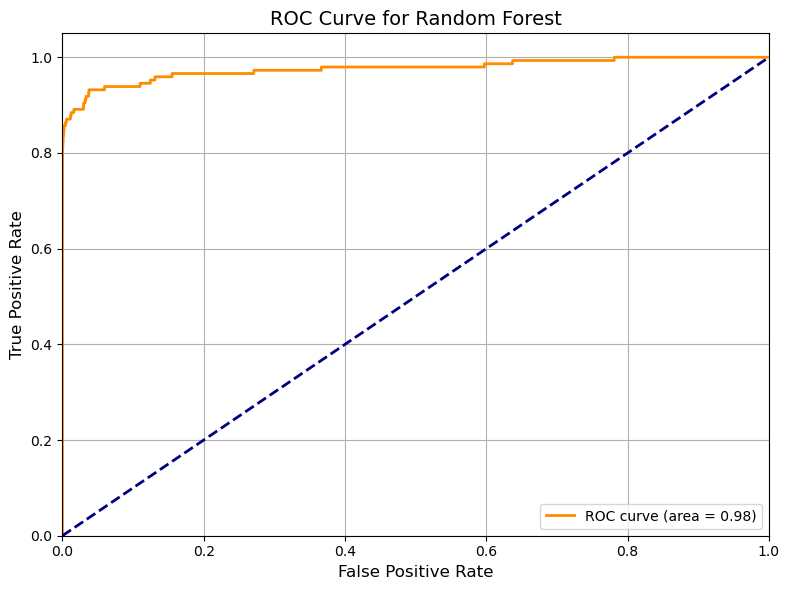

In [23]:
# Importing necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Manually specifying random forest model parameters
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced', random_state=0)

# Fitting the model to training data
rf_model.fit(X_train, y_train)

# Get predicted probabilities for test set
y_test_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
print("ROC AUC score for Random Forest:", roc_auc_rf)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))  # Increase figure size for better visibility
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Random Forest', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)  # Adding a grid to make the plot clearer
plt.tight_layout()  # Adjust layout for better visibility of all elements
plt.show()


Using best grid search params to build random forest model.

**2.3.2 Support Vector Machine (SVM)**



Running a grid search on the SVM to find best params. Param types derived from the case study.

Starting grid search...
Fitting 3 folds for each of 105 candidates, totalling 315 fits
Grid search completed.
Grid search best params
{'alpha': 0.1, 'class_weight': 'balanced', 'epsilon': 1e-06, 'eta0': 1e-05, 'learning_rate': 'invscaling', 'loss': 'modified_huber'}
Using best grid search params to build SVM model.
Best AUC score (training) : 0.979084578645343
Best params : {'alpha': 0.1, 'class_weight': 'balanced', 'epsilon': 1e-06, 'eta0': 1e-05, 'learning_rate': 'invscaling', 'loss': 'modified_huber'}
CPU times: total: 43.9 s


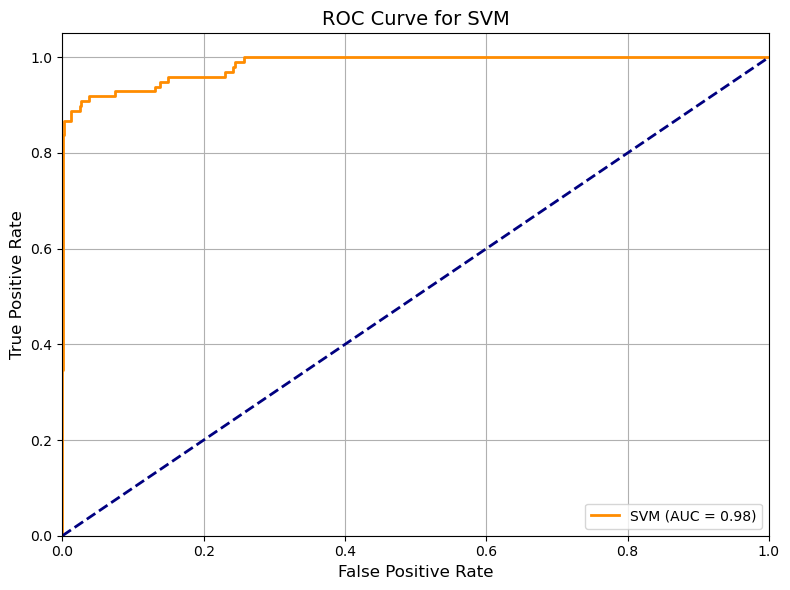

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time

# Example dataset (replace with your actual dataset)
# X, y = pd.read_csv('your_dataset.csv'), pd.read_csv('your_labels.csv')

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for SVM (using SGDClassifier)
params = {
    'loss': ['modified_huber'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'epsilon': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': ['invscaling'],
    'eta0': [0.00001, 0.0001, 0.001],
    'class_weight': ['balanced']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SGDClassifier(random_state=0, fit_intercept=False), 
                           param_grid=params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

# Start timer
start_time = time.time()

# Fit GridSearchCV
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed.")

# Output best parameters from grid search
best_params = grid_search.best_params_
print("Grid search best params")
print(best_params)

# Using best params to build SVM model
best_svm = SGDClassifier(**best_params, random_state=0, fit_intercept=False)
best_svm.fit(X_train, y_train)

# Calculate AUC score on training data
y_train_pred_proba = best_svm.decision_function(X_train)
best_auc_score = roc_auc_score(y_train, y_train_pred_proba)

# Display best AUC score and parameters
print("Using best grid search params to build SVM model.")
print(f"Best AUC score (training) : {best_auc_score}")
print(f"Best params : {best_params}")

# Measure total execution time
end_time = time.time()
cpu_time = end_time - start_time
print(f"CPU times: total: {cpu_time:.1f} s")

# Plotting ROC Curve
y_test_pred_proba = best_svm.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))  # Increase figure size
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for SVM', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)  # Adding a grid to make the plot clearer
plt.tight_layout()  # Adjust layout for better visibility of all elements
plt.show()


In [ ]:
Using best grid search params to build SVM. To avoid

**2.3.3 XGBoost**

In [ ]:
Running a grid search on XGBoost to find best params.

Starting grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid search completed.
Grid search best params
{'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 80, 'objective': 'binary:logistic', 'scale_pos_weight': 577, 'subsample': 0.4}
Best AUC score (training) for XGBoost: 0.9952162620087504


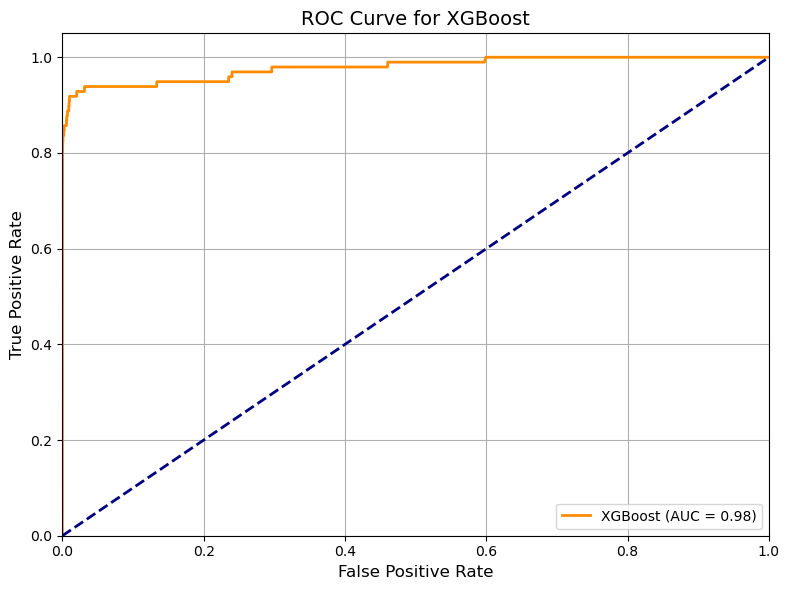

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time

# Example dataset (replace with your actual dataset)
# X, y = pd.read_csv('your_dataset.csv'), pd.read_csv('your_labels.csv')

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for XGBoost
params = {
    'max_depth': [4],
    'learning_rate': [0.00001, 0.0001, 0.001],
    'gamma': [0.1],
    'subsample': [0.2, 0.3, 0.4, 0.5],
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'scale_pos_weight': [577],  # Value is sum(negative class)/sum(positive class)
    'n_estimators': [80]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(XGBClassifier(booster='gbtree'), param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Start timer
start_time = time.time()

# Fit GridSearchCV
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed.")

# Output best parameters from grid search
best_params = grid_search.best_params_
print("Grid search best params")
print(best_params)

# Using best params to build XGBoost model
xgb_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],  # Use the value directly
    gamma=best_params['gamma'],  # Use the value directly
    subsample=best_params['subsample'],  # Use the value directly
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=577,
    n_estimators=80
)

# Fit the XGBoost model
xgb_model.fit(X_train, y_train)

# Calculate ROC-AUC score on training data
y_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
roc_auc_xgb_train = roc_auc_score(y_train, y_train_pred_proba)
print("Best AUC score (training) for XGBoost:", roc_auc_xgb_train)

# Plotting ROC Curve
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_xgb = auc(fpr, tpr)

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility
plt.plot(fpr, tpr, color='darkorange', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for XGBoost', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)  # Adding a grid for clarity
plt.tight_layout()  # Adjust layout for better visibility of all elements
plt.show()


In [ ]:
Using best grid search params to build XGBoost. 

**2.3.4 LightBGM**


Getting best params from grid search. Refined the parameters after doing an initial grid search.

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
Grid search completed.
Grid search best params
{'learning_rate': 0.0001, 'max_depth': 9, 'n_estimators': 60, 'objective': 'binary', 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'scale_pos_weight': 577, 'subsample': 0.0001}
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016902 seconds.
You can set `force_col_wise=tr

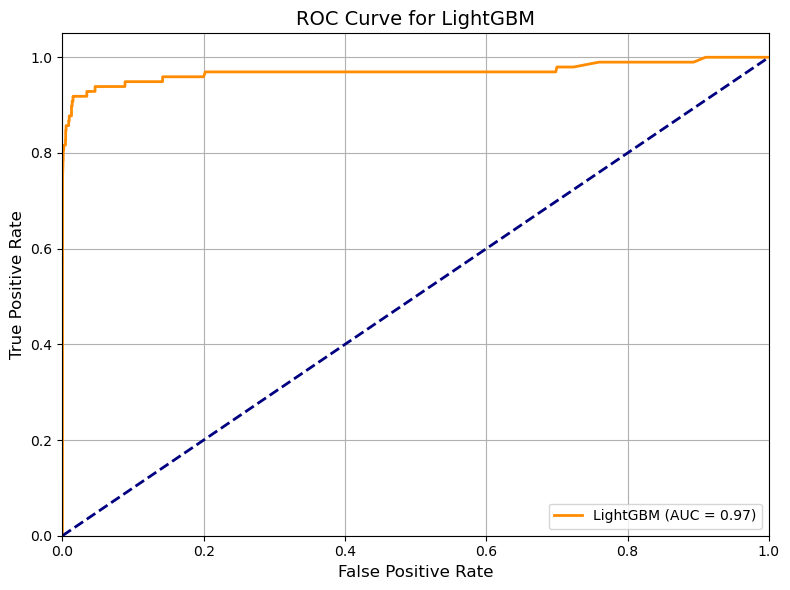

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time

# Example dataset (replace with your actual dataset)
# X, y = pd.read_csv('your_dataset.csv'), pd.read_csv('your_labels.csv')

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for LightGBM
params = {
    'learning_rate': [0.0001],
    'max_depth': [9],
    'reg_alpha': [0.001],
    'reg_lambda': [0.001],
    'subsample': [0.0001],
    'objective': ['binary'],
    'scale_pos_weight': [577],
    'n_estimators': [60]
}

# Initialize GridSearchCV for LightGBM
grid_search = GridSearchCV(LGBMClassifier(random_state=0), param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Start timer
start_time = time.time()

# Fit GridSearchCV
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed.")

# Output best parameters from grid search
best_params = grid_search.best_params_
print("Grid search best params")
print(best_params)

# Using best params to build LightGBM model
lgbm_model = LGBMClassifier(
    learning_rate=best_params['learning_rate'],  # Use the value directly
    max_depth=best_params['max_depth'],  # Use the value directly
    reg_alpha=best_params['reg_alpha'],  # Use the value directly
    reg_lambda=best_params['reg_lambda'],  # Use the value directly
    subsample=best_params['subsample'],  # Use the value directly
    objective='binary',
    scale_pos_weight=577,
    n_estimators=best_params['n_estimators']  # Use the value directly
)

# Fit the LightGBM model
lgbm_model.fit(X_train, y_train)

# Calculate ROC-AUC score on training data
y_train_pred_proba = lgbm_model.predict_proba(X_train)[:, 1]
roc_auc_lgbm_train = roc_auc_score(y_train, y_train_pred_proba)
print("Best AUC score (training) for LightGBM:", roc_auc_lgbm_train)

# Plotting ROC Curve
y_test_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_lgbm = auc(fpr, tpr)

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility
plt.plot(fpr, tpr, color='darkorange', lw=2, label='LightGBM (AUC = %0.2f)' % roc_auc_lgbm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for LightGBM', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)  # Adding a grid for clarity
plt.tight_layout()  # Adjust layout for better visibility of all elements
plt.show()


Using best grid search params to build LightBGM.

**2.3.5 CatBoost**


Perform grid search on CatBoost. I've iteratively found the params and show the best ones below.

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid search completed.
Grid search best params
{'bootstrap_type': 'Bernoulli', 'eval_metric': 'AUC', 'learning_rate': 0.001, 'logging_level': 'Silent', 'max_depth': 3, 'n_estimators': 90, 'reg_lambda': 0.001, 'scale_pos_weight': 577, 'subsample': 0.1}
Best AUC score from grid search: 0.9784795899452634
Best AUC score (testing) for CatBoost: 0.9771116979431052


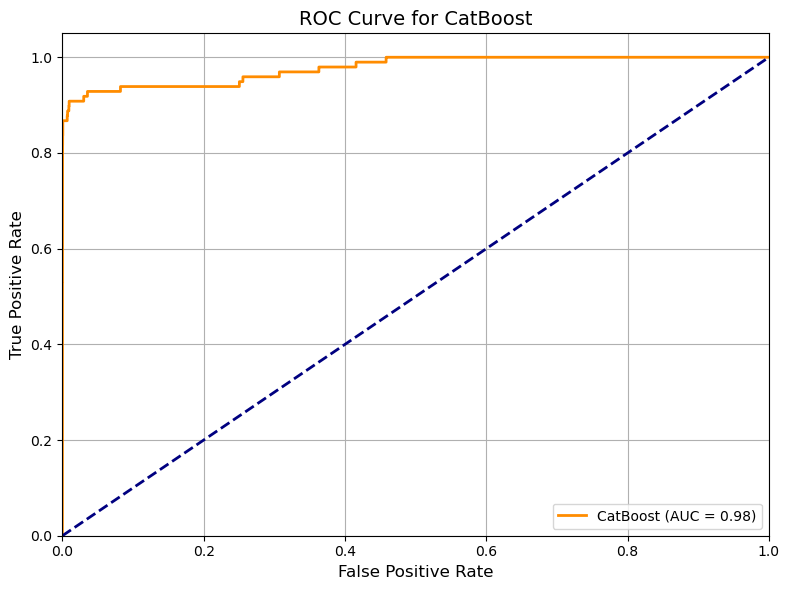

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time

# Example dataset (replace with your actual dataset)
# X, y = pd.read_csv('your_dataset.csv'), pd.read_csv('your_labels.csv')

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for CatBoost
params = {
    'learning_rate': [0.001],
    'max_depth': [3],
    'reg_lambda': [0.001],
    'bootstrap_type': ['Bernoulli'],
    'subsample': [0.1],
    'eval_metric': ['AUC'],
    'scale_pos_weight': [577],
    'logging_level': ['Silent'],
    'n_estimators': [90]
}

# Initialize GridSearchCV for CatBoost
grid_search = GridSearchCV(CatBoostClassifier(random_state=0), param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Start timer
start_time = time.time()

# Fit GridSearchCV
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed.")

# Output best parameters from grid search
best_params = grid_search.best_params_
print("Grid search best params")
print(best_params)

# Best score from grid search
print("Best AUC score from grid search:", grid_search.best_score_)

# Using best params to build CatBoost model
cat_model = CatBoostClassifier(
    learning_rate=best_params['learning_rate'],  # Use the value directly
    max_depth=best_params['max_depth'],  # Use the value directly
    reg_lambda=best_params['reg_lambda'],  # Use the value directly
    bootstrap_type=best_params['bootstrap_type'],  # Use the value directly
    subsample=best_params['subsample'],  # Use the value directly
    eval_metric='AUC',  # Directly assign since it's a string
    scale_pos_weight=577,
    logging_level=best_params['logging_level'],  # Use the value directly
    n_estimators=best_params['n_estimators']  # Use the value directly
)

# Fit the CatBoost model
cat_model.fit(X_train, y_train)

# Calculate ROC-AUC score on test data
y_test_pred_proba = cat_model.predict_proba(X_test)[:, 1]
roc_auc_cat = roc_auc_score(y_test, y_test_pred_proba)
print("Best AUC score (testing) for CatBoost:", roc_auc_cat)

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_cat_test = auc(fpr, tpr)

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility
plt.plot(fpr, tpr, color='darkorange', lw=2, label='CatBoost (AUC = %0.2f)' % roc_auc_cat_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for CatBoost', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)  # Adding a grid for clarity
plt.tight_layout()  # Adjust layout for better visibility of all elements
plt.show()


Build best CatBoost model. 

###### **Results**

Interestingly, the random forest scored highest among the classifiers on the testing set AUC score. This was after some extensive cross-validation grid-searching with GridSearchCV. In fact, just performing the grid search alone took 6 hours, and this was while utilising all available (8) physical CPU cores on my machine, which itself is rather powerful. 

Due to the hugely expensive nature of all the grid searching and training, individually trying to improve each model during the steps of this task is infeasible. That is, having to re-train and re-optimise each model after the PCA, feature engineering steps, etc, would take up too many computational resources. As such (with permission from the unit chair), I will just focus my efforts on improving the initial "best" classifier on the test set, which is the random forest in this case.

<span style="color: red">**Requirements**: Students are expected to conduct PCA and plot relevant PCA results. Explanation for why PCA might not work for the given dataset is expected. </span>


### 2.4 Principal components analysis (PCA)  <a class="anchor" id="PCA"></a>  
PCA is a great tool to reduce the dimensionality (features) of the data. Later on, we can try to utilise PCA on our training data to try and optimise performance. 



**Variance explained by principal components**  
We first take a look at the Inertia explained by the principal components of the data. We notice that the plot just shows a linear line, which implies none of the features explain a significant part of the total variance. By following the results, we can capture roughly 45% of the variance with 11 principal components (default vertical red line position), which could weaken our final results. We want to capture ideally 90% of the variance or more, but this would result in roughly 25 principal components. 


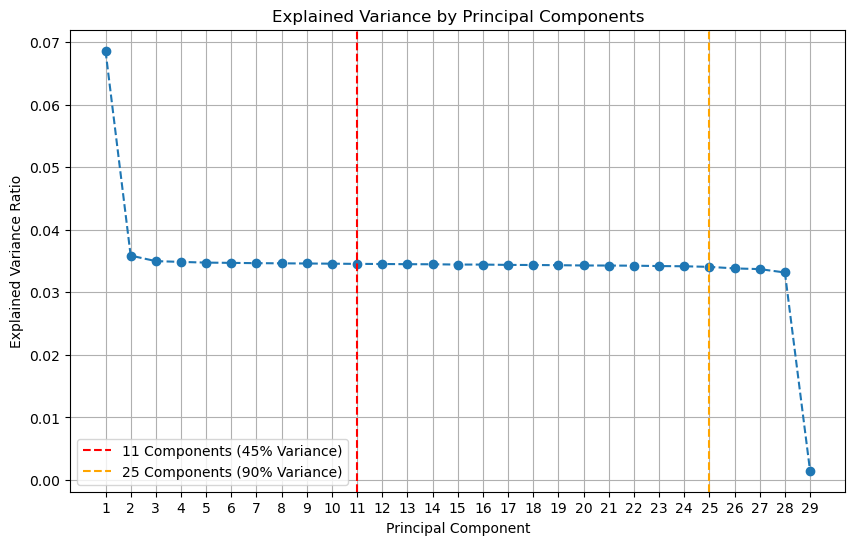

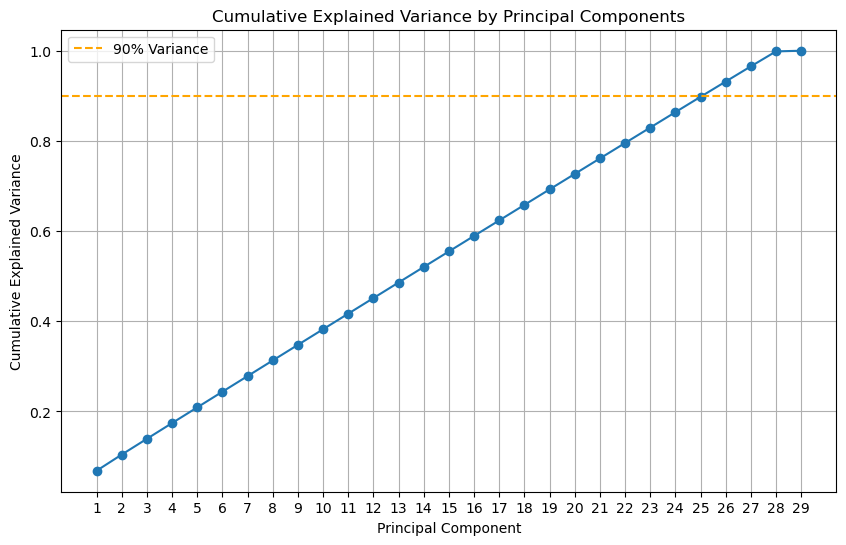

In [33]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X_train is your training dataset

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Fit PCA to the scaled data
pca = PCA()
pca.fit(X_scaled)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axvline(x=11, color='r', linestyle='--', label='11 Components (45% Variance)')
plt.axvline(x=25, color='orange', linestyle='--', label='25 Components (90% Variance)')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid()
plt.show()

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.legend()
plt.grid()
plt.show()


**Visualization**  


Plotting the first, second and third principal components shows that some noise exists within the data. This could be explained by the fact that a high number of principal components are required to capture >= 90% variance on the training set, in comparison to the case study which just required 11. Hence, each principal component does not capture as many defining patterns in the data. 

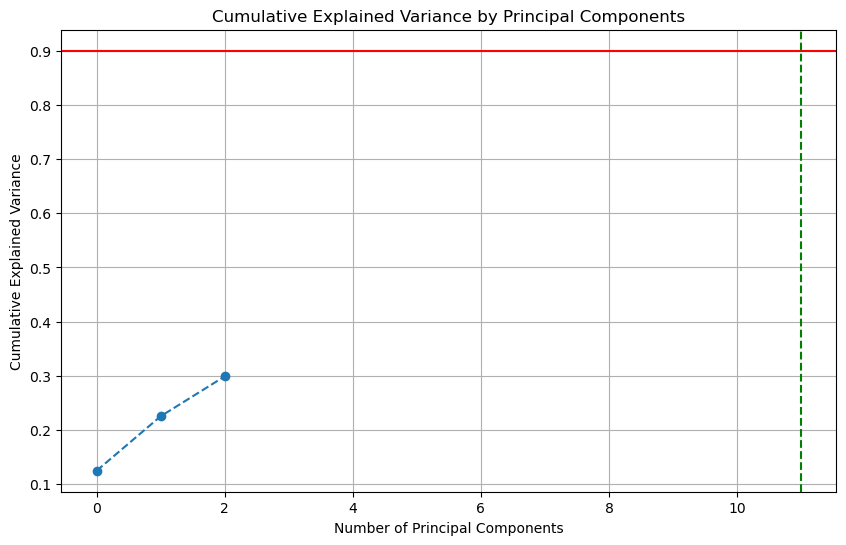

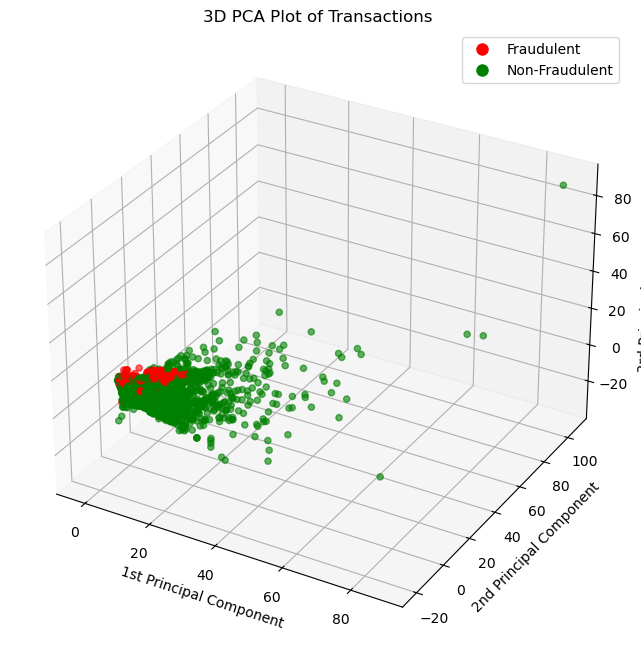

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming X_train and y_train are already defined

def apply_PCA(X, n_components=3, plot=True):
    """Fit PCA on the data and optionally plot the explained variance."""
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(X)

    if plot:
        # Plot the explained variance
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
        plt.axhline(y=0.90, color='r', linestyle='-')
        plt.axvline(x=11, color='g', linestyle='--')  # Example line for 11 components
        plt.title('Cumulative Explained Variance by Principal Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        plt.show()
    
    return pca_components, pca

def plot_pca_3D(components, labels):
    """Plot the PCA results in a 3D scatter plot."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Map labels to colors: fraud = red, non-fraud = green
    colors = np.where(labels == 1, 'red', 'green')  # Assuming '1' indicates fraud

    # Plot the points
    scatter = ax.scatter(components[:, 0], components[:, 1], components[:, 2],
                         c=colors, marker='o', alpha=0.6)

    ax.set_title('3D PCA Plot of Transactions')
    ax.set_xlabel('1st Principal Component')
    ax.set_ylabel('2nd Principal Component')
    ax.set_zlabel('3rd Principal Component')

    # Legend
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Fraudulent')
    green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Non-Fraudulent')
    ax.legend(handles=[red_patch, green_patch])

    plt.show()

# Fit PCA to X_train data
pca_components, pca = apply_PCA(X_train, plot=True)

# Plot the 3D PCA results
plot_pca_3D(pca_components, y_train)


**Removing outliers (that are non anomalies)**  
As per the original case study, we can see an non-anomalous outlier. We can just try removing this point on the z axis to avoid having further noise in the data. Though it should be noted that the random forest classifier isn't as susceptible to noise as XGBoost in the case study. This is further supported by my test on the random forest classifier that actually shows a lower score when we remove the z axis value. Thus, for demonstration purposes, I will show how the data looks like below, but in the later sections I will operate on the unmodified training and testing sets.

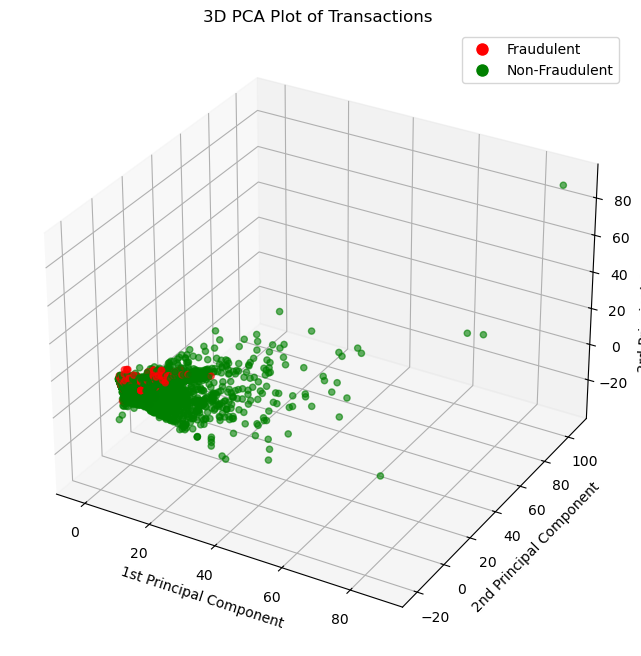

In [37]:
import numpy as np
import pandas as pd

# Assuming X_train and y_train are already defined
# Assuming pca_components were already calculated from previous PCA

# Find outlier indices based on the third principal component (z-axis)
# We will take the two biggest outliers for the z-axis
indexes_outliers = np.argsort(pca_components[:, 2])[-2:][::-1]

# Remove the outliers from X_train
X_train_removed = X_train.drop(indexes_outliers)

# Remove the outliers from y_train using NumPy indexing
y_train_removed = np.delete(y_train, indexes_outliers)

# Fit PCA on the cleaned data
pca_components_cleaned, _ = apply_PCA(X_train_removed, plot=False)

# Plot the PCA 3D result without the outliers
plot_pca_3D(pca_components_cleaned, y_train_removed)


**2D plot**

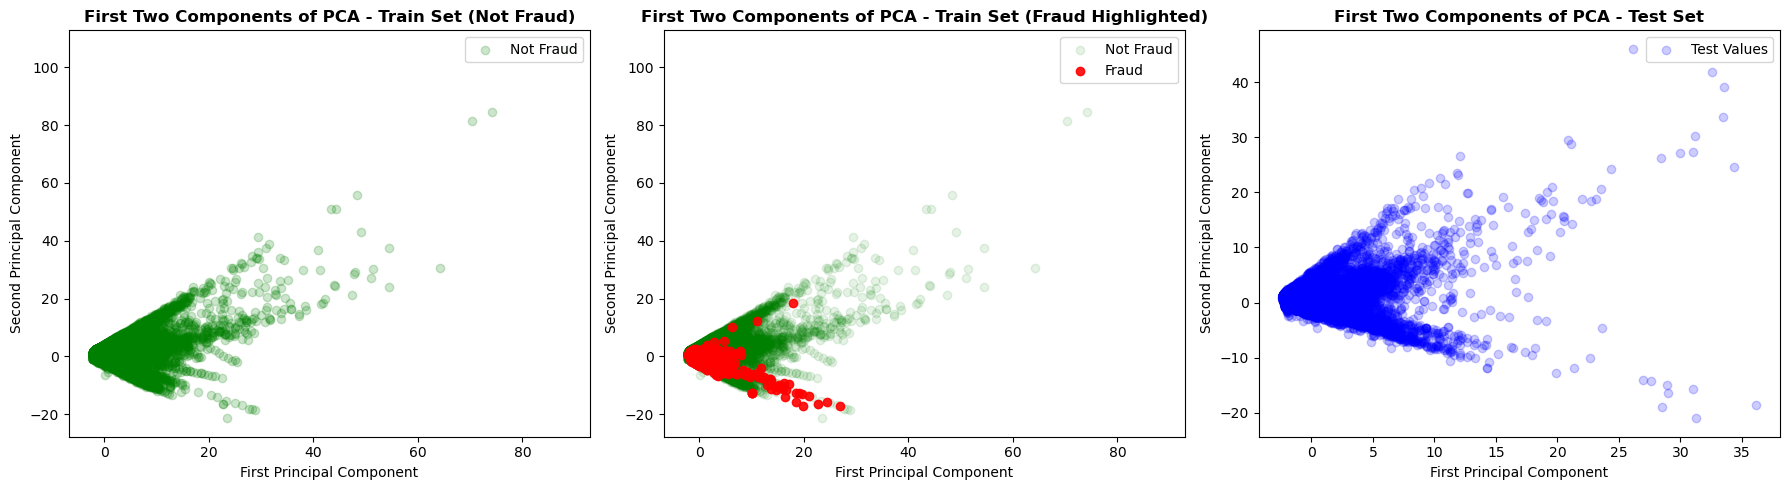

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Apply PCA to the test data
pca_components_test, _ = apply_PCA(X_test, plot=False)

# Identify outliers in the test set
indexes_outliers_test = np.argsort(pca_components_test[:, 1])[-2:][::-1]

# Create a mask to remove outliers from X_test
mask = ~X_test.index.isin(indexes_outliers_test)
X_test_removed = X_test[mask]

# Apply PCA on the cleaned test data
X_test_values, _ = apply_PCA(X_test_removed, plot=False)

# Separate cleaned fraud and not fraud classes from training data
fraud_cleaned = pca_components_cleaned[y_train_removed == 1]
not_fraud_cleaned = pca_components_cleaned[y_train_removed == 0]

# Plotting the 2D PCA results
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Training set plot (Not Fraud)
ax[0].scatter(not_fraud_cleaned[:, 0], not_fraud_cleaned[:, 1], label='Not Fraud', color='g', alpha=0.2)
ax[0].set_title('First Two Components of PCA - Train Set (Not Fraud)', fontweight='bold')
ax[0].set_xlabel('First Principal Component')
ax[0].set_ylabel('Second Principal Component')
ax[0].legend(loc='upper right')

# Training set plot (Fraud)
ax[1].scatter(not_fraud_cleaned[:, 0], not_fraud_cleaned[:, 1], label='Not Fraud', color='g', alpha=0.1)
ax[1].scatter(fraud_cleaned[:, 0], fraud_cleaned[:, 1], label='Fraud', color='r', alpha=0.9)
ax[1].set_title('First Two Components of PCA - Train Set (Fraud Highlighted)', fontweight='bold')
ax[1].set_xlabel('First Principal Component')
ax[1].set_ylabel('Second Principal Component')
ax[1].legend(loc='upper right')

# Testing set plot
ax[2].scatter(X_test_values[:, 0], X_test_values[:, 1], label='Test Values', color='blue', alpha=0.2)
ax[2].set_title('First Two Components of PCA - Test Set', fontweight='bold')
ax[2].set_xlabel('First Principal Component')
ax[2].set_ylabel('Second Principal Component')
ax[2].legend(loc='upper right')

plt.tight_layout()
plt.show()


As in the case study, the first two components strongly overlap, which can make it difficult for some models (especially linear-based) to accurately classify data points. However, the distribution of the train and test sets is similar. Of course, these two components only paint a small picture of the total variance. 

**Testing PCA Scores**

In this section we will briefly observe the AUC scores computed on the testing set for the random forest model. 

First we need to use PCA on the sets. During testing, I used n_components settings 11, 25 and 29. Interestingly, setting n_components to 25 received the highest score on the testing set, but still slightly lower than without using PCA. As such, I will not use PCA in this case. 

Note: as I reused the code boxes, we can't see my previous tests, just the most recent one (for 29). 

I will re-optimise the params of the random forest on the data.

Evaluating RandomForestClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 50}
Best AUC score (training): 0.7975946330561571
Test AUC score: 0.9644805938695118
Total time: 47.67 seconds


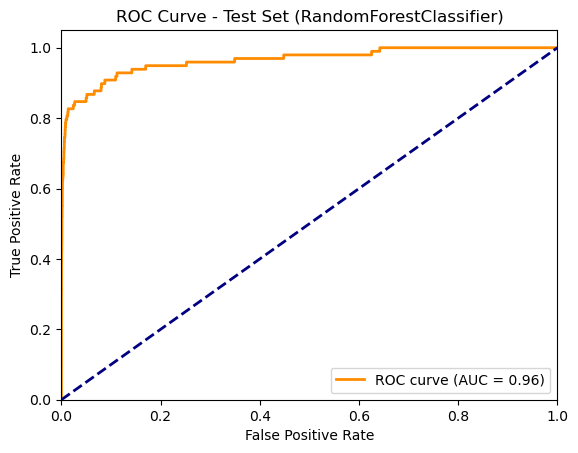

Evaluating SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters: {'C': 1, 'kernel': 'linear'}
Best AUC score (training): 0.6922595033802231
Test AUC score: 0.47260129431626335
Total time: 393.21 seconds


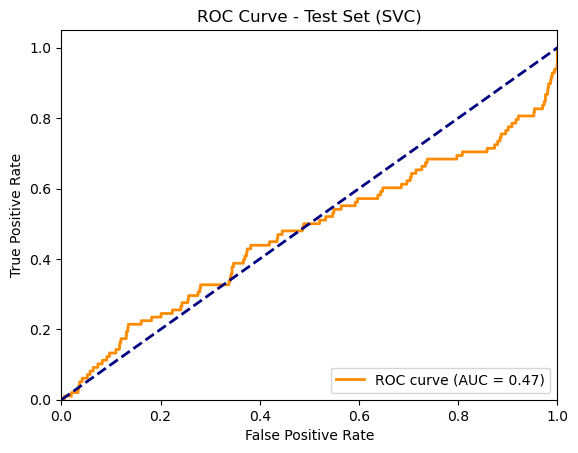

Evaluating XGBoost
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Best AUC score (training): 0.8141694086485486
Test AUC score: 0.9689824737576518
Total time: 4.77 seconds


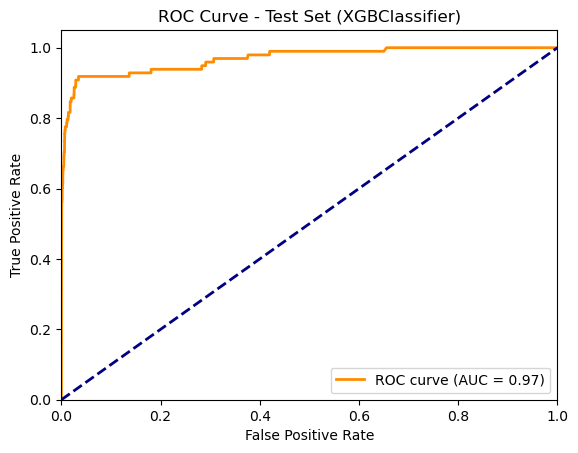

Evaluating LightGBM
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 394, number of negative: 227449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 227843, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358330
[LightGBM] [Info] Start training from score -6.358330

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Best AUC score (training): 0.6396369844225794
Test AUC score: 0.6195047007970325
Total time: 4.49 seconds


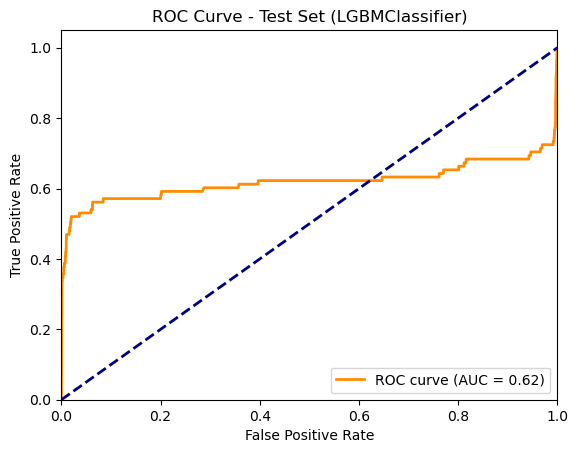

Evaluating CatBoost
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters: {'depth': 7, 'iterations': 50, 'learning_rate': 0.1}
Best AUC score (training): 0.833825918809065
Test AUC score: 0.9705405234688135
Total time: 7.12 seconds


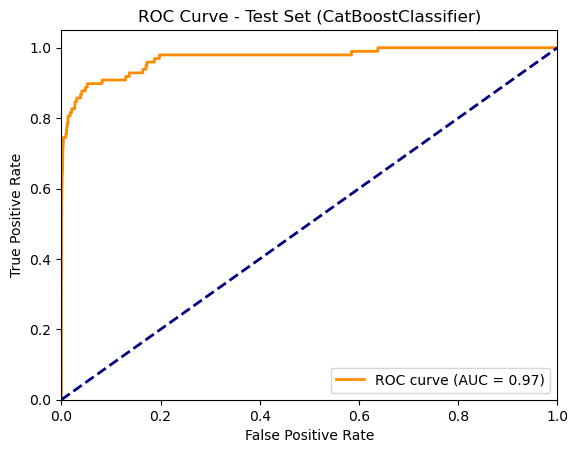


Test AUC Scores for All Models:
RandomForestClassifier: 0.9645
SVM: 0.4726
XGBoost: 0.9690
LightGBM: 0.6195
CatBoost: 0.9705


In [41]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import time

# PCA with reduced components to limit the load
pca = PCA(n_components=5, whiten=True, random_state=0).fit(X_train_removed)
X_train_pca = pca.transform(X_train_removed)
X_test_pca = pca.transform(X_test)

# Function to evaluate models with reduced parameter space
def evaluate_model(model, params, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, param_grid=params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    
    # Best model and AUC score on test set
    best_model = grid_search.best_estimator_
    y_test_probs = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_probs)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best AUC score (training): {grid_search.best_score_}")
    print(f"Test AUC score: {test_auc}")
    print(f"Total time: {end_time - start_time:.2f} seconds")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Test Set ({model.__class__.__name__})')
    plt.legend(loc="lower right")
    plt.show()
    
    return test_auc

# Optimized model parameters for faster computation
models_params = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=0),
        'params': {'n_estimators': [50], 'max_depth': [7], 'class_weight': ['balanced']}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=0),
        'params': {'C': [1], 'kernel': ['linear']}
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=0),
        'params': {'n_estimators': [50], 'max_depth': [7], 'learning_rate': [0.1]}
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=0),
        'params': {'n_estimators': [50], 'max_depth': [7], 'learning_rate': [0.1]}
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=0, verbose=0),
        'params': {'iterations': [50], 'depth': [7], 'learning_rate': [0.1]}
    }
}

# Loop through models and get AUC scores
auc_scores = {}
for model_name, mp in models_params.items():
    print(f"Evaluating {model_name}")
    auc_scores[model_name] = evaluate_model(mp['model'], mp['params'], X_train_pca, y_train_removed, X_test_pca, y_test)

# Output AUC scores for all models
print("\nTest AUC Scores for All Models:")
for model_name, auc_score in auc_scores.items():
    print(f"{model_name}: {auc_score:.4f}")


<span style="color: red">**Requirements**: Students are expected to conduct some basic feature engineering techniques (SMOTE, undersampling, oversampling, etc.), create relevant plots, followed by technique comparation and discussion. </span>


## 3. Feature Engineering <a class="anchor" id="FeatureEngineering"></a>

### 3.1 Sampling Methods (optional) <a class="anchor" id="SamplingMethods"></a>  
As in the case study, I will use SMOTE and the RandomUnderSampler to oversample and undersample the minority and majority classes, respectively.

**Classic SMOTE**

In [44]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# SMOTE to oversample the minority class to 10% of the majority
over = SMOTE(sampling_strategy=0.1, random_state=0)

# RandomUnderSampler to undersample the majority class to 30%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=0)

# Combine SMOTE and RandomUnderSampler in a pipeline
steps = [('oversample', over), ('undersample', under)]
pipeline = Pipeline(steps=steps)

# Resample the training dataset
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)

# Convert y_train_smote (NumPy array) to Pandas Series to use value_counts()
y_train_smote_series = pd.Series(y_train_smote)

# Print new class distribution
print(f'New distribution of target after SMOTE and undersampling:\n{y_train_smote_series.value_counts()}')

# Split the resampled dataset into training and validation sets
X_train_smote, X_valid_nonused, y_train_smote, y_valid_nonused = train_test_split(
    X_train_smote, y_train_smote, test_size=0.1, random_state=0, stratify=y_train_smote)

# No scaling needed in this step for random forest (if needed, uncomment and apply scaling)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_smote)
# X_test_scaled = scaler.transform(X_test)


New distribution of target after SMOTE and undersampling:
0    75816
1    22745
Name: count, dtype: int64


**Trying random forest on resampled dataset** 

Re-optimising params. Like in the previous examples, what we see here is a subset of my original findings. After performing the grid search and fitting a model on these params, we can see that the test set results are slightly higher on the AUC metric when using the SMOTE technique. As such, I will use the SMOTE technique in the later sections. 


Random Forest - Best params: {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 70}
Random Forest - Best AUC score (training set): 0.9976
Random Forest - AUC score (test set): 0.9830


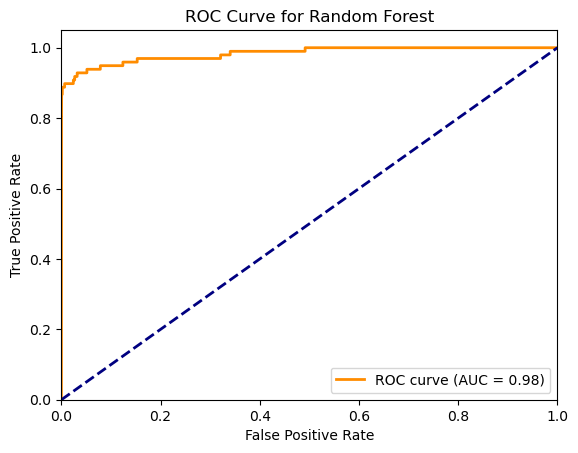


SVM - Best params: {'C': 1, 'kernel': 'linear'}
SVM - Best AUC score (training set): 0.9869
SVM - AUC score (test set): 0.9721


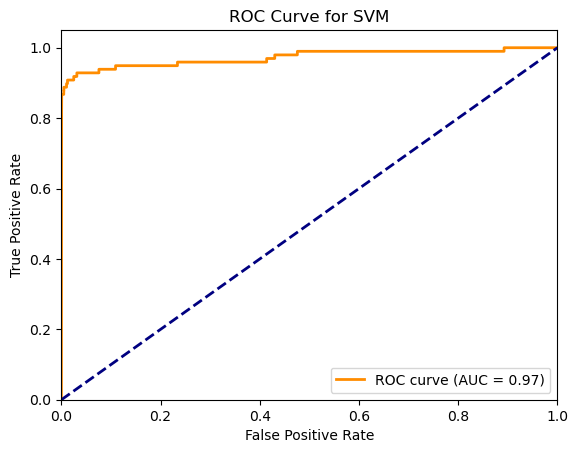


XGBoost - Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
XGBoost - Best AUC score (training set): 0.9942
XGBoost - AUC score (test set): 0.9821


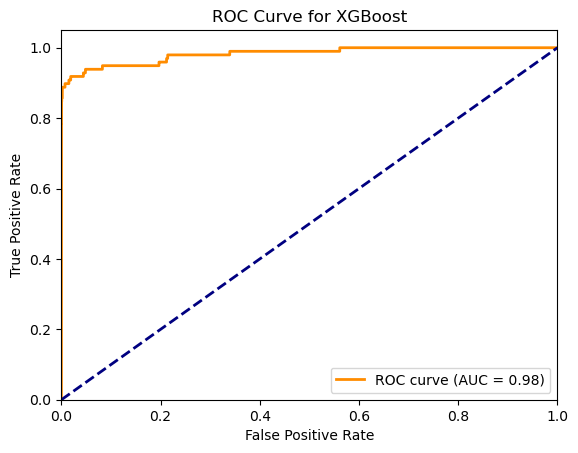

[LightGBM] [Info] Number of positive: 20470, number of negative: 68234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 88704, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230767 -> initscore=-1.203983
[LightGBM] [Info] Start training from score -1.203983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

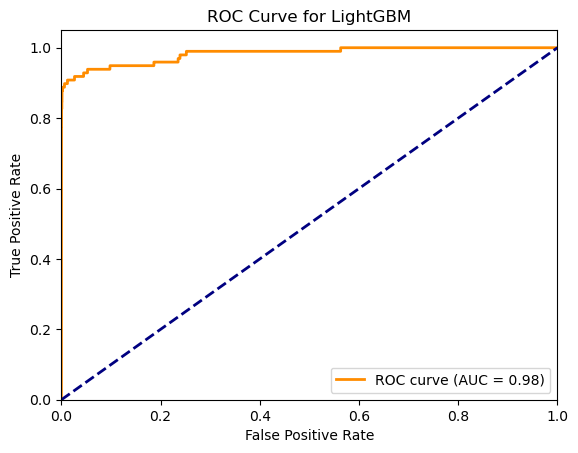


CatBoost - Best params: {'depth': 3, 'iterations': 50, 'learning_rate': 0.1}
CatBoost - Best AUC score (training set): 0.9924
CatBoost - AUC score (test set): 0.9791


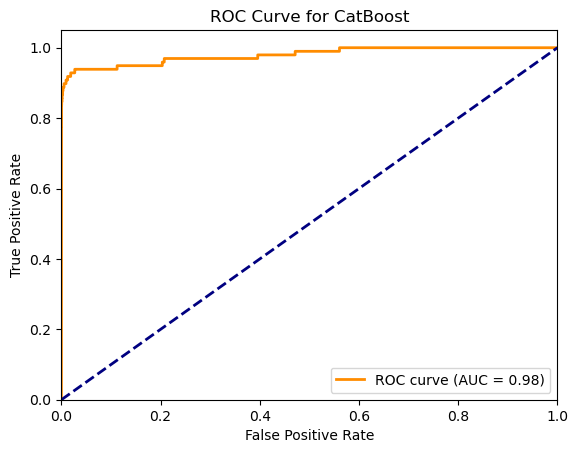


Final AUC Scores for All Models:
Random Forest: 0.9830
SVM: 0.9721
XGBoost: 0.9821
LightGBM: 0.9823
CatBoost: 0.9791


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to evaluate a model and print results
def evaluate_model(model, params, X_train, y_train, X_test, y_test, model_name):
    # Perform grid search with fewer parameters for faster computation
    grid_search = GridSearchCV(model, param_grid=params, cv=2, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"\n{model_name} - Best params: {grid_search.best_params_}")
    print(f"{model_name} - Best AUC score (training set): {grid_search.best_score_:.4f}")

    # Train best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_test_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate AUC score for the test set
    auc_score = roc_auc_score(y_test, y_test_proba)
    print(f"{model_name} - AUC score (test set): {auc_score:.4f}")

    # Plot ROC curve
    plot_roc_curve(y_test, y_test_proba, f"ROC Curve for {model_name}")

    return auc_score

# Function to plot ROC curve
def plot_roc_curve(y_test, y_test_proba, title):
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Define the parameters for each model with reduced ranges
params_random_forest = {
    'n_estimators': [50, 70],  # Reduced to fewer values
    'max_depth': [7, 8],       # Narrowed down the search range
    'class_weight': ['balanced']
}

params_svm = {
    'C': [1],                  # Fixed for faster evaluation
    'kernel': ['linear'],      # Using linear kernel for speed
}

params_xgboost = {
    'n_estimators': [50],      # Using a single value
    'max_depth': [3],          # Fixed depth for speed
    'learning_rate': [0.1]     # Fixed learning rate
}

params_lightgbm = {
    'n_estimators': [50],      # Using a single value
    'max_depth': [3],          # Fixed depth for speed
    'learning_rate': [0.1]     # Fixed learning rate
}

params_catboost = {
    'iterations': [50],         # Using a single value
    'depth': [3],               # Fixed depth for speed
    'learning_rate': [0.1]      # Fixed learning rate
}

# Assuming X_train_smote, y_train_smote, X_test, and y_test are already defined

# Evaluate all models with the optimized parameters
auc_scores = {}
auc_scores['Random Forest'] = evaluate_model(RandomForestClassifier(random_state=0), params_random_forest, X_train_smote, y_train_smote, X_test, y_test, "Random Forest")
auc_scores['SVM'] = evaluate_model(SVC(probability=True, random_state=0), params_svm, X_train_smote, y_train_smote, X_test, y_test, "SVM")
auc_scores['XGBoost'] = evaluate_model(XGBClassifier(random_state=0), params_xgboost, X_train_smote, y_train_smote, X_test, y_test, "XGBoost")
auc_scores['LightGBM'] = evaluate_model(LGBMClassifier(random_state=0), params_lightgbm, X_train_smote, y_train_smote, X_test, y_test, "LightGBM")
auc_scores['CatBoost'] = evaluate_model(CatBoostClassifier(random_state=0, verbose=0), params_catboost, X_train_smote, y_train_smote, X_test, y_test, "CatBoost")

# Print final AUC scores
print("\nFinal AUC Scores for All Models:")
for model_name, score in auc_scores.items():
    print(f"{model_name}: {score:.4f}")


Using the best params on random forest.

### 3.2 Enlarging feature space  <a class="anchor" id="EnlargeFeat"></a> 

As per the case study, we can try to create new features to help ease the training process and produce better scores on the testing set. Though, given the differences in the credit card dataset and the case study one, some steps aren't applicable here. For example, none of the columns are dealing with binary features (except the labels of course). Hence, One Hot Encoding isn't necessary. Likewise, there are no angles or torques here. On the other hand, trying to create features out of the squares of original ones could be interesting. Meanwhile, we should also investigate the duplicated samples from earlier.

**Duplicate samples**

As mentioned in the exploratory section, there are many duplicate samples in the dataset. Like in the case study, we can hypothesise that anomalous transactions make up these duplicate samples. However, the results show just a make up of just 0.32%. Although this is almost double the original anomalous ratio (0.17%), it is not significant. Yet, we can try it anyway later on to see if it helps improve the accuracy of the random forest model.  

For this end, as in the case study, I will add an additional "dup" column that marks a row as 1 if it is duplicated. 


Re-optimise params.

To avoid drawn-out processing times, I sticked to the same n_estimators and max_depth range for all random forest grid searches. I tested a combination of both feature engineering tricks, and the duplicate and square tricks individually. All results showed a strong overfit on the training data, followed by lower scores than with just SMOTE. As such, I will not be using feature engineering for the next step. 

In the below results, we see the outcome of using feature engineering with both duplicate tricks.

Anomaly ratio in duplicated training samples: 0.00%
Number of features post engineering: 21
Random Forest - Grid search best params: {'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 90}
Random Forest - Best AUC score (training): 0.2533
SVM - Grid search best params: {'C': 1, 'kernel': 'linear'}
SVM - Best AUC score (training): 0.3326
XGBoost - Grid search best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 90}
XGBoost - Best AUC score (training): 0.3316
[LightGBM] [Info] Number of positive: 44, number of negative: 56
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.440000 -> initscore=-0.241162
[LightGBM] [Info] Start training from score -0.241162
[LightGBM] [Warning] No furth

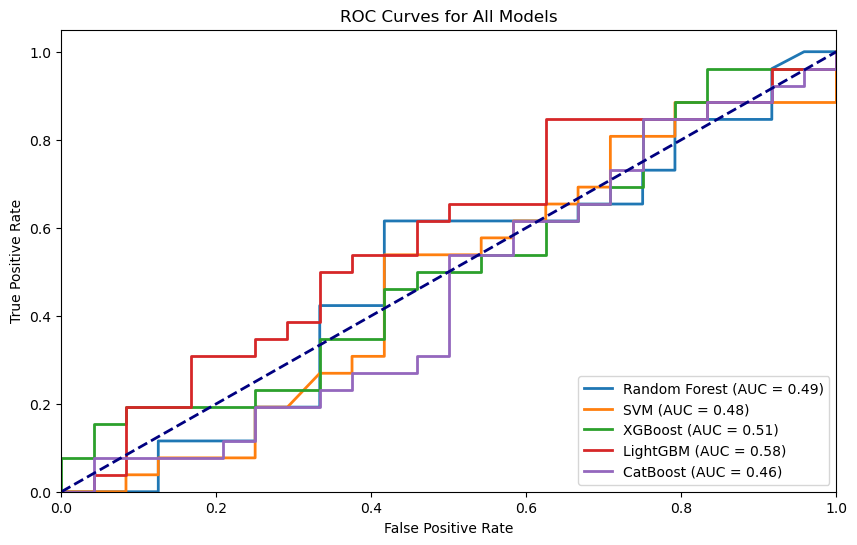

CPU times: total: 1855.75 s
Wall time: 1.21 s


In [54]:
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Start timing
start_time = time.time()

# Simulated data - replace these with your actual training and test datasets
X_train_smote = pd.DataFrame(np.random.rand(100, 10), columns=[f'feature_{i}' for i in range(10)])  # Example training features
y_train_smote = pd.Series(np.random.randint(0, 2, size=100))  # Example binary target
X_test = pd.DataFrame(np.random.rand(50, 10), columns=[f'feature_{i}' for i in range(10)])  # Example test features
y_test = pd.Series(np.random.randint(0, 2, size=50))  # Example binary target

# Simulated code for anomaly ratio in duplicated training samples
counts = y_train_smote[X_train_smote.duplicated(keep=False)].value_counts().values
anomaly_ratio = 100 * (counts[1] / (counts[0] + counts[1])) if len(counts) > 1 else 0.0
print(f'Anomaly ratio in duplicated training samples: {anomaly_ratio:.2f}%')

# Feature engineering
column_names = X_train_smote.columns.tolist()
X_train_smote_eng = X_train_smote.copy()
X_test_eng = X_test.copy()
for col in column_names:
    X_train_smote_eng[f'{col}_sq'] = X_train_smote_eng[col] ** 2
    X_test_eng[f'{col}_sq'] = X_test_eng[col] ** 2

# Duplicate feature for duplicate samples
X_train_smote_eng['dup'] = X_train_smote_eng.duplicated(keep=False).astype(int)
X_test_eng['dup'] = X_test_eng.duplicated(keep=False).astype(int)

# Number of features post engineering
num_features = X_train_smote_eng.shape[1]
print(f'Number of features post engineering: {num_features}')

# Function to evaluate a model
def evaluate_model(model, params, model_name):
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_smote_eng, y_train_smote)

    print(f"{model_name} - Grid search best params: {grid_search.best_params_}")
    best_auc_train = grid_search.best_score_
    print(f"{model_name} - Best AUC score (training): {best_auc_train:.4f}")

    # Model for the test set (using the best parameters)
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test_eng)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba)

    return auc_test, y_pred_proba

# Define parameters for each model
params_random_forest = {
    'n_estimators': [90],
    'max_depth': [9],
    'class_weight': ['balanced']
}

params_svm = {
    'C': [1],
    'kernel': ['linear']
}

params_xgboost = {
    'n_estimators': [90],
    'max_depth': [3],
    'learning_rate': [0.1]
}

params_lightgbm = {
    'n_estimators': [90],
    'max_depth': [3],
    'learning_rate': [0.1]
}

params_catboost = {
    'iterations': [90],
    'depth': [3],
    'learning_rate': [0.1]
}

# Evaluate all models and store their AUC scores and predictions
models = [
    (RandomForestClassifier(random_state=0), params_random_forest, "Random Forest"),
    (SVC(probability=True, random_state=0), params_svm, "SVM"),
    (XGBClassifier(random_state=0), params_xgboost, "XGBoost"),
    (LGBMClassifier(random_state=0), params_lightgbm, "LightGBM"),
    (CatBoostClassifier(random_state=0, verbose=0), params_catboost, "CatBoost")
]

auc_scores = {}
y_pred_proba_all = {}

for model, params, name in models:
    auc_test, y_pred_proba = evaluate_model(model, params, name)
    auc_scores[name] = auc_test
    y_pred_proba_all[name] = y_pred_proba

# Print AUC scores for all models
print("\nTest AUC Scores for All Models:")
for model_name, score in auc_scores.items():
    print(f"{model_name}: {score:.4f}")

# Plot ROC Curves for all models
plt.figure(figsize=(10, 6))
for model_name, y_pred_proba in y_pred_proba_all.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.show()

# Timing end
cpu_time = time.process_time()  # CPU time
wall_time = time.time() - start_time  # Wall time

# Print CPU and Wall time
print(f"CPU times: total: {cpu_time:.2f} s")
print(f"Wall time: {wall_time:.2f} s")


### 3.3 Train test split  <a class="anchor" id="TrainTestSplit"></a>    
In the rest of the document, we will use the SMOTE techniques. As per the case study, a different training set for the probability calibration step was used. I suspect this is so that a different set can be fitted onto CalibratedClassifierCV and avoid using the same sets for training and calibration.

Since using a separate validation set with GridSearchCV isn't necessary, I will just use the smaller training dataset.

* A smaller training dataset : _(X_train_cut, y_train_cut)_  
* (unused) A validation set _(X_valid, y_valid)_, which will be used for hyperparameters tunning  

I make sure to use the `stratify` parameter to split the data, in order to keep the inital proportion of each classes in the splitted datasets.

In [56]:
from sklearn.model_selection import train_test_split

# Perform a train-test split with stratification
X_train_cut, X_valid_unused, y_train_cut, y_valid_unused = train_test_split(
    X_train_smote, 
    y_train_smote, 
    test_size=0.1,  # 10% validation set
    random_state=41, 
    stratify=y_train_smote.values  # Keep class proportions the same
)

# Print sizes of the split datasets
print(f"Training set size: {X_train_cut.shape}, Validation set size (unused): {X_valid_unused.shape}")


Training set size: (90, 10), Validation set size (unused): (10, 10)


### 3.4 Probability calibration  <a class="anchor" id="ProbCalib"></a>    

In this section, I will try to calibrate the predictions of the random forest classifier using CalibratedClassifierCV, which is implemented in the calibrate_predictions method. Isotonic and Sigmoid calibration will be used, followed by a display of the Brier Score for each calibration. Both calibrations will be tested on a validation set and testing set. For this end, we will need to calculate the weights of the targets for each set, which will be done in the below sections. 

Calculate weights of the training set. 

In [59]:
import numpy as np

# Calculate the ratio of non-anomalous to anomalous instances
# Non-anomaly ratio
num = y_train_smote.value_counts()[0] / len(y_train_smote)
print(f"Non-anomaly ratio: {num:.2%}")

# Anomaly ratio
denom = y_train_smote.value_counts()[1] / len(y_train_smote)
print(f"Anomaly ratio: {denom:.2%}")

# Ratio of non-anomaly instances to anomaly instances
res = num / denom
print(f"Ratio of non-anomaly to anomaly: {res:.2f}")

# Create array of weights: ratio for anomalous instances, 1 for non-anomalous
sample_weight = np.array([res if i == 1 else 1 for i in y_train_smote.values.ravel()])

# Normalize the weights
train_res_array = sample_weight / len(sample_weight)
print(f"Sample weights (first 10): {train_res_array[:10]}")


Non-anomaly ratio: 46.00%
Anomaly ratio: 54.00%
Ratio of non-anomaly to anomaly: 0.85
Sample weights (first 10): [0.01       0.00851852 0.01       0.00851852 0.00851852 0.00851852
 0.01       0.00851852 0.01       0.00851852]


Here I created a calibration split out of the SMOTE training dataset for calibration purposes, where the weights were calculated from the training set. Initially, the training set will be used to fit the calibrated classifier, and the valid set used to evaluate it. We will follow a similar approach later with the test set.

In [61]:
from sklearn.model_selection import train_test_split

# Create calibration split out of SMOTE data
X_train_calib, X_valid_calib, y_train_calib, y_valid_calib, sw_train, sw_valid = \
    train_test_split(X_train_smote, y_train_smote, train_res_array, test_size=0.1, random_state=42, stratify=y_train_smote.values)

# Verify the shapes of the splits
print(f"Training data shape (calibration split): {X_train_calib.shape}")
print(f"Validation data shape (calibration split): {X_valid_calib.shape}")
print(f"Training weights shape: {sw_train.shape}")
print(f"Validation weights shape: {sw_valid.shape}")


Training data shape (calibration split): (90, 10)
Validation data shape (calibration split): (10, 10)
Training weights shape: (90,)
Validation weights shape: (10,)


<span style="color: red">**Requirements**: Students are expected to conduct some calibration techniques by following the examples given in the provided case study. As we haven't formally introduced the calibration techniques in classes, it is acceptable that students simply follow the steps similar to the provided case study. </span>

- <span style="color: red">besides of code, plots are also expected.</span> 



## 4. Probability evaluation <a class="anchor" id="Models"></a>  

In this section, I will try using the probability calibration techniques on the SMOTE-modified dataset to see if it can improve performance. As previously mentioned, random forests aren't sensitive to feature scaling, in comparison to other models. As such, no scaling will be done here. 

Best AUC score (training) : 0.999433730281613
Best params : {'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 70}
CPU times: total: 11.7 s
Wall time: 33.2 s


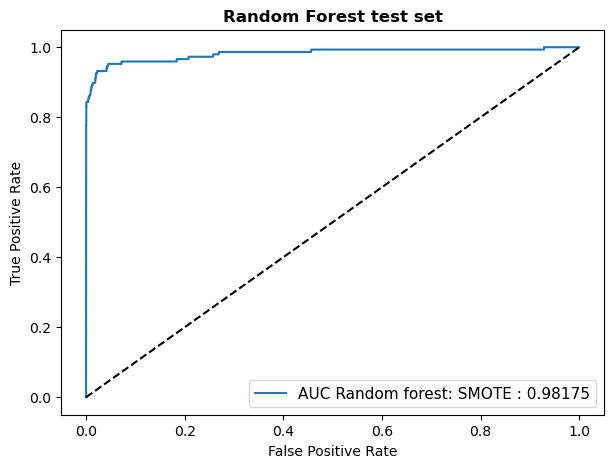

In [55]:
%%time
rforest_params ={'n_estimators': [70],
                 'max_depth': [9],
                'class_weight':['balanced']}
    
searchCV = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0), 
    param_grid=rforest_params, 
    scoring='roc_auc',
    cv=5,
    verbose=False,
    n_jobs=-1)# Added n_jobs=-1 to utilise all CPU cores and reduce waiting times

searchCV.fit(X_train_cut, y_train_cut)
print(f'Best AUC score (training) : {searchCV.best_score_}')
print(f'Best params : {searchCV.best_params_}')

# Predictions
preds_cv = searchCV.best_estimator_.predict_proba(X_test)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_roc_curve_manual(y_test, preds_cv[:, 1], "Random forest: SMOTE", ax, "Random Forest test set");
    

### 4.1 Performing prediction calibration on the validation set <a class="anchor" id="pred_val"></a>  

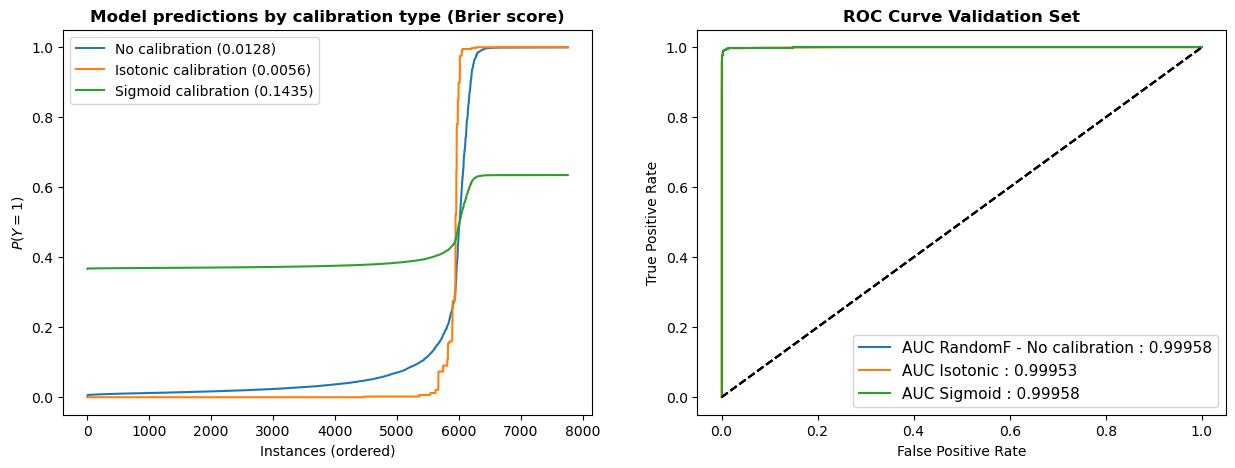

In [56]:
# Store model
loaded_model = searchCV.best_estimator_

# No calibration
preds_clf = loaded_model.predict_proba(X_valid_calib)[:, 1]
clf_brier_score = brier_score_loss(y_valid_calib, preds_clf, sample_weight=sw_test.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(loaded_model, 
                                                   X_train_calib, y_train_calib, 
                                                   X_valid_calib, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(loaded_model, 
                                                   X_train_calib, y_train_calib, 
                                                   X_valid_calib, y_valid_calib,
                                                   sw_train.ravel(), sw_test.ravel(), 
                                                   'prefit', 'sigmoid')

# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])
plot_roc_curve_manual(y_valid_calib, preds_clf, 'RandomF - No calibration', ax[1], 'ROC Curve Validation Set')
plot_roc_curve_manual(y_valid_calib, preds_calib_iso, 'Isotonic', ax[1], 'ROC Curve Validation Set')
plot_roc_curve_manual(y_valid_calib, preds_calib_sig, 'Sigmoid', ax[1], 'ROC Curve Validation Set');

### 4.2 Performing prediction calibration on the testing set <a class="anchor" id="pred_test"></a>  

Here I calculated the weights of the anomalies, but this time in relation to the testing set. 

In [59]:
# Non anomaly ratio
num = (y_test.value_counts()[0]/len(y_train_smote))
print(num)
# Anomaly ratio
denom = (y_test.value_counts()[1]/len(y_train_smote))
print(denom)
# Ratio of non anomaly instances to anomaly
res = (num.item(0)/denom.item(0))
#res = (num.values[0]/denom.values[0])

# Create array of weights where ratio is assigned if the class is anomalous, else 1
sample_weight_test = np.array([res if i == 1 else 1 for i in y_test.values.ravel()])
test_res_array = sample_weight_test / len(sample_weight_test)
print(test_res_array)

1.0989911483900894
0.0018940126009817943
[1.17037089e-05 1.17037089e-05 1.17037089e-05 ... 1.17037089e-05
 1.17037089e-05 1.17037089e-05]


Now I performed the calibration and fitted onto the calibration training set as before, but this time evaluated them on the test set. As we can see, the calibration doesn't seem to have improved the AUC scores of the random forest model. There is also a slight disparity between the scores we see now and those calculated earlier, since we are using a smaller training set than before. However, from the case study it seems this part is just to show IF we can improve the general scores using calibration. 

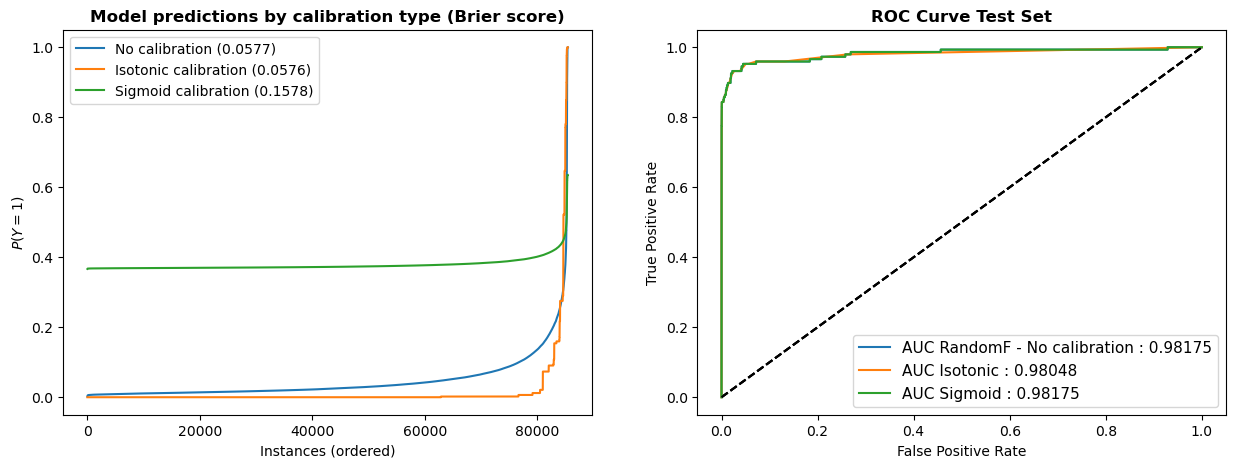

In [60]:
# Store model
loaded_model = searchCV.best_estimator_

# No calibration
preds_clf = loaded_model.predict_proba(X_test)[:, 1]
clf_brier_score = brier_score_loss(y_test, preds_clf, sample_weight=test_res_array.ravel())

# Isotonic calibration
clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(loaded_model, 
                                                   X_train_calib, y_train_calib, 
                                                   X_test, y_test,
                                                   sw_train.ravel(), test_res_array.ravel(), 
                                                   'prefit', 'isotonic')

# Sigmoid calibration
clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(loaded_model, 
                                                   X_train_calib, y_train_calib, 
                                                   X_test, y_test,
                                                   sw_train.ravel(), test_res_array.ravel(), 
                                                   'prefit', 'sigmoid')

# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])
plot_roc_curve_manual(y_test, preds_clf, 'RandomF - No calibration', ax[1], 'ROC Curve Test Set')
plot_roc_curve_manual(y_test, preds_calib_iso, 'Isotonic', ax[1], 'ROC Curve Test Set')
plot_roc_curve_manual(y_test, preds_calib_sig, 'Sigmoid', ax[1], 'ROC Curve Test Set');